In [23]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
# import glob2 as glob
import matplotlib as mpl

import matplotlib.pyplot as plt
import pickle
from scipy.stats import linregress
from aux_funcs import compressed_read, format_plot
from copy import deepcopy as copy
from nb_analysis_tools import *
from scipy.stats import beta

plt.rcParams['font.family'] = 'Helvetica Light'

# import matplotlib.font_manager
# font_names = [x for x in sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist])]
# print(font_names)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
def parse_behavioral_data(d, env_idx):
    features = [
        'agent_in_patch',
        'current_patch_start',
        'reward_bounds',
        'current_patch_num',
        'action',
        'current_position',
        'reward',
        'patch_reward_param',
        'current_reward_site_attempted',
    ]

    features_to_time_series_dict = {}
    for f in features:
        features_to_time_series_dict[f] = []
        
    for k in np.arange(len(d)):
        for f in features:
            features_to_time_series_dict[f].append(d[k][f][env_idx])
            
    for f in features:
        try:
            features_to_time_series_dict[f] = np.array(features_to_time_series_dict[f])
        except e:
            print(e)

    all_dwell_times = []
    rewards_at_positions = [0]
    reward_attempted_at_positions = [False]
    dwell_time = 0
    last_p = None
    rewards_seen_in_patch = np.zeros((len(d)))
    
    for i, p in enumerate(features_to_time_series_dict['current_position']):
        if last_p is not None and (p != last_p):
            all_dwell_times.append(dwell_time)
            rewards_at_positions.append(0)
            reward_attempted_at_positions.append(False)
            dwell_time = 0
        if last_p is not None:
            dwell_time += 1
        rewards_at_positions[-1] += features_to_time_series_dict['reward'][i]
        reward_attempted_at_positions[-1] = True if features_to_time_series_dict['current_reward_site_attempted'][i] else reward_attempted_at_positions[-1]
        last_p = p

        if features_to_time_series_dict['agent_in_patch'][i]:
            if i > 0:
                rewards_seen_in_patch[i] = rewards_seen_in_patch[i-1] + features_to_time_series_dict['reward'][i]
            else:
                rewards_seen_in_patch[i] = features_to_time_series_dict['reward'][i]
    
    features_to_time_series_dict['rewards_at_positions'] = np.array(rewards_at_positions)
    features_to_time_series_dict['reward_attempted_at_positions'] = np.array(reward_attempted_at_positions)
    features_to_time_series_dict['all_dwell_times'] = np.array(all_dwell_times)
    features_to_time_series_dict['rewards_seen_in_patch'] = rewards_seen_in_patch

    return features_to_time_series_dict

In [4]:
def clopper_pearson(k, n, alpha=0.05):
    lower = np.where(k == 0, 0, beta.ppf(alpha / 2, k, n - k + 1))
    upper = np.where(k == n, 1., beta.ppf(1 - alpha / 2, k + 1, n - k))
    return np.stack([lower, upper])

In [27]:
def plot_session(data_path, env_idx, update_num=None, xlim=None, max_reward_param=30, max_reward_sites=8):

    b_data_raw = load_behavioral_data(data_path, update_num).__next__()
    b_data = parse_behavioral_data(b_data_raw, env_idx)

    rewards_at_positions = b_data['rewards_at_positions']
    reward_attempted_at_positions = b_data['reward_attempted_at_positions']
    all_patch_nums = b_data['current_patch_num']
    all_patch_reward_params = b_data['patch_reward_param']
    rewards_seen_in_patch = b_data['rewards_seen_in_patch']
              
    scale = 0.8
    fig, axs = plt.subplots(1, 1, figsize=(10 * scale, 3 * scale))
    
    axs.plot(np.arange(len(b_data['all_dwell_times'])), 1/np.array(b_data['all_dwell_times']), c='black', zorder=0)
    axs.scatter(np.arange(len(rewards_at_positions))[rewards_at_positions > 0], rewards_at_positions[rewards_at_positions > 0] * 2, c='blue', marker='*')
    axs.scatter(np.arange(len(reward_attempted_at_positions))[reward_attempted_at_positions > 0], reward_attempted_at_positions[reward_attempted_at_positions > 0] * 2.5, c='black', marker='s')
    
    reward_param_of_stop = []
    site_idx_of_stop =  []
    site_stops_for_patch_type = np.zeros((all_patch_nums.max() + 1, max_reward_sites))
    site_stop_opportunities_for_patch_type = np.zeros((all_patch_nums.max() + 1, max_reward_sites))
    acc_reward_stops_for_patch_type = np.zeros((all_patch_nums.max() + 1, 40))
    acc_reward_stop_opportunities_for_patch_type = np.zeros((all_patch_nums.max() + 1, 40))
    patches_entered_for_patch_type = np.zeros((all_patch_nums.max() + 1,))
    reward_param_for_patch_type = np.zeros((all_patch_nums.max() + 1,))

    cmap = mpl.colormaps['magma']
    
    s_0 = 1.1
    s_1 = 1.75
    last_pstart = None
    pb = None
    last_reward_site_start = None
    reward_site_start = None
    patch_count = 0
    rw_site_counter = 0
    plotted_cnt = 0

    for i, pstart in enumerate(b_data['current_patch_start']):
        # print(f'Step {i}')
        if last_pstart is None or (pstart != last_pstart).any():
            patches_entered_for_patch_type[all_patch_nums[i]] += 1
            reward_param_for_patch_type[all_patch_nums[i]] = all_patch_reward_params[i]
            patch_count += 1
            pb = [pstart, pstart]
            c = cmap(all_patch_reward_params[i] / max_reward_param) if all_patch_reward_params[i] > 0 else 'black'
            rw_site_counter = 0
        
        rwsb = copy(b_data['reward_bounds'][i])
        reward_site_start = int(rwsb[0])
        # print('rwsite_start', reward_site_start)
        # print('last_rwsite_start', last_reward_site_start)
        if last_reward_site_start is None or not np.isclose(last_reward_site_start, reward_site_start): # this is a new reward site
            axs.fill_between(list(rwsb), s_0 * np.ones(2), y2=s_1 * np.ones(2), alpha=0.5, color=c, zorder=-1)
            axs.fill_between(list(rwsb), np.zeros(2), y2=s_0 * np.ones(2), alpha=0.2, color=c, zorder=-1)

            if rewards_seen_in_patch[i] < 40:
                acc_reward_stop_opportunities_for_patch_type[all_patch_nums[i], int(rewards_seen_in_patch[i])] += 1

            if rw_site_counter < max_reward_sites:
                    site_stop_opportunities_for_patch_type[all_patch_nums[i], rw_site_counter] += 1
            
            if np.sum(reward_attempted_at_positions[int(rwsb[0]):int(rwsb[1])]) == 0: # site not attempted
                pb[1] = rwsb[1]
                axs.fill_between(pb, s_0 * np.ones(2), s_1 * np.ones(2), alpha=0.2, color=c, zorder=-2)
                axs.fill_between(pb, np.zeros(2), s_0 * np.ones(2), alpha=0.05, color=c, zorder=-2)
            else: # site attempted
                reward_param_of_stop.append(b_data['patch_reward_param'][i])
                site_idx_of_stop.append(rw_site_counter)
                
                if rw_site_counter < max_reward_sites:
                    site_stops_for_patch_type[all_patch_nums[i], rw_site_counter] += 1

                if rewards_seen_in_patch[i] < 40:
                    acc_reward_stops_for_patch_type[all_patch_nums[i], int(rewards_seen_in_patch[i])] += 1
                    
                rw_site_counter += 1
        
        last_pstart = pstart
        last_reward_site_start = reward_site_start

    if xlim is not None:
        axs.set_xlim(xlim[0], xlim[1])
    axs.set_ylim(0)
    axs.set_ylabel('Avg. running speed')
    axs.set_xlabel('Position')
    axs.set_yticks([0, 1])
    format_plot(axs, axislabelsize=13, ticklabelsize=12, leftspine=False)
    fig.tight_layout()
    fig.savefig('../../results/figures/raw_behavioral_trace.png')
    
    print('Patch count:', patch_count)

    labels = [
        'Unrewarded',
        'Low reward',
        'High reward',
    ]
    
    scale = 1.5
    fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)
    # mx = site_stops_for_patch_type.max()
    x = np.arange(site_stops_for_patch_type.shape[1])
    for k in range(site_stops_for_patch_type.shape[0]):
        c = cmap(reward_param_for_patch_type[k] / max_reward_param) if reward_param_for_patch_type[k] > 0 else 'black'
        cis = clopper_pearson(site_stops_for_patch_type[k, :], site_stop_opportunities_for_patch_type[k, 0])
        print(cis.shape)
        axs[k].fill_between(x, cis[0, :], cis[1, :], color=c, alpha=0.2)
        axs[k].plot(x, site_stops_for_patch_type[k, :] / site_stop_opportunities_for_patch_type[k, 0], color=c, label=labels[k])
        axs[k].set_ylim(0, 1.1)
    axs[1].set_ylabel('Fraction attempted')
    axs[2].set_xlabel('Reward site number in patch')
    fig.legend()
    format_plot(axs, axislabelsize=13, ticklabelsize=12)
    fig.tight_layout()
    fig.savefig('../../results/figures/behavioral_stops_stats_rws_frac_given_entered.png')

    scale = 1.5
    fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)
    # mx = site_stops_for_patch_type.max()
    x = np.arange(site_stops_for_patch_type.shape[1])
    for k in range(site_stops_for_patch_type.shape[0]):
        c = cmap(reward_param_for_patch_type[k] / max_reward_param) if reward_param_for_patch_type[k] > 0 else 'black'
        site_stop_opportunities_for_patch_type[k, :] = np.where(site_stop_opportunities_for_patch_type[k, :] == 0, np.nan, site_stop_opportunities_for_patch_type[k, :])
        cis = clopper_pearson(site_stops_for_patch_type[k, :], site_stop_opportunities_for_patch_type[k, :])
        print(cis.shape)
        axs[k].fill_between(x, cis[0, :], cis[1, :], color=c, alpha=0.2)
        axs[k].plot(x, site_stops_for_patch_type[k, :] / site_stop_opportunities_for_patch_type[k, :], color=c, label=labels[k])
        axs[k].set_ylim(0, 1.1)
    axs[1].set_ylabel('Fraction attempted')
    axs[2].set_xlabel('Reward site number in patch')
    fig.legend()
    format_plot(axs, axislabelsize=13, ticklabelsize=12)
    fig.tight_layout()
    fig.savefig('../../results/figures/behavioral_stops_stats_rws_frac_given_site.png')

    scale = 1.5
    fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)
    # mx = site_stops_for_patch_type.max()
    x = np.arange(site_stops_for_patch_type.shape[1])
    for k in range(site_stops_for_patch_type.shape[0]):
        c = cmap(reward_param_for_patch_type[k] / max_reward_param) if reward_param_for_patch_type[k] > 0 else 'black'
        if k == 0:
            axs[k].bar(x, site_stop_opportunities_for_patch_type[k, :], color='gray', alpha=0.5, label='Sites entered')
        else:
            axs[k].bar(x, site_stop_opportunities_for_patch_type[k, :], color='gray', alpha=0.5)
        axs[k].bar(x, site_stops_for_patch_type[k, :], color=c, label=labels[k])
        # axs[k].set_ylim(0, 1.1)
    axs[1].set_ylabel('Counts')
    axs[2].set_xlabel('Reward site number in patch')
    fig.legend()
    format_plot(axs, axislabelsize=13, ticklabelsize=12)
    fig.tight_layout()
    fig.savefig('../../results/figures/behavioral_stops_stats_rws_counts.png')

    scale = 1.5
    fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)
    # mx = site_stops_for_patch_type.max()
    x = np.arange(acc_reward_stops_for_patch_type.shape[1])
    for k in range(acc_reward_stops_for_patch_type.shape[0]):
        c = cmap(reward_param_for_patch_type[k] / max_reward_param) if reward_param_for_patch_type[k] > 0 else 'black'
        acc_reward_stop_opportunities_for_patch_type[k, :] = np.where(acc_reward_stop_opportunities_for_patch_type[k, :] == 0, np.nan, acc_reward_stop_opportunities_for_patch_type[k, :])
        cis = clopper_pearson(acc_reward_stops_for_patch_type[k, :], acc_reward_stop_opportunities_for_patch_type[k, :])
        axs[k].fill_between(x, cis[0, :], cis[1, :], color=c, alpha=0.2)
        axs[k].plot(x, acc_reward_stops_for_patch_type[k, :] / acc_reward_stop_opportunities_for_patch_type[k, :], color=c, label=labels[k])
        axs[k].set_ylim(0, 1.1)
    axs[0].set_xlim(-1)
    axs[1].set_ylabel('Fraction attempted')
    axs[2].set_xlabel('Total reward in patch')
    fig.legend()
    format_plot(axs, axislabelsize=13, ticklabelsize=12)
    fig.tight_layout()
    fig.savefig('../../results/figures/behavioral_stops_stats_reward_frac.png')

    scale = 1.5
    fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)
    # mx = site_stops_for_patch_type.max()
    x = np.arange(acc_reward_stops_for_patch_type.shape[1])
    for k in range(acc_reward_stops_for_patch_type.shape[0]):
        c = cmap(reward_param_for_patch_type[k] / max_reward_param) if reward_param_for_patch_type[k] > 0 else 'black'
        if k == 0:
            axs[k].bar(x, acc_reward_stop_opportunities_for_patch_type[k, :], color='grey', alpha=0.5, label='Stop opportunities')
        else:
            axs[k].bar(x, acc_reward_stop_opportunities_for_patch_type[k, :], color='grey', alpha=0.5)
        axs[k].bar(x, acc_reward_stops_for_patch_type[k, :], color=c, label=labels[k])
        # axs[k].set_ylim(0, 1.1)
    axs[0].set_xlim(-1, 22)
    axs[1].set_ylabel('Counts')
    axs[2].set_xlabel('Total reward in patch')
    fig.legend()
    format_plot(axs, axislabelsize=13, ticklabelsize=12)
    fig.tight_layout()
    fig.savefig('../../results/figures/behavioral_stops_stats_reward_counts.png')
    
    print(reward_param_for_patch_type)

['00050.pkl', '00100.pkl', '00150.pkl', '00200.pkl', '00250.pkl', '00300.pkl', '00350.pkl', '00400.pkl', '00450.pkl', '00500.pkl', '00550.pkl', '00600.pkl', '00650.pkl', '00700.pkl', '00750.pkl', '00800.pkl', '00850.pkl', '00900.pkl', '00950.pkl', '01000.pkl', '01050.pkl', '01100.pkl', '01150.pkl', '01200.pkl', '01250.pkl', '01300.pkl', '01350.pkl', '01400.pkl', '01450.pkl', '01500.pkl', '01550.pkl', '01600.pkl', '01650.pkl', '01700.pkl', '01750.pkl', '01800.pkl', '01850.pkl', '01900.pkl', '01950.pkl', '02000.pkl', '02050.pkl', '02100.pkl', '02150.pkl', '02200.pkl']


C:\Users\david.bell\AppData\Local\Temp\ipykernel_2748\1171141402.py:15: RuntimeWarning: divide by zero encountered in divide
  axs.plot(np.arange(len(b_data['all_dwell_times'])), 1/np.array(b_data['all_dwell_times']), c='black', zorder=0)


Axes(0.125,0.11;0.775x0.77)
Patch count: 251
(2, 30)
(2, 30)
(2, 30)
[<Axes: > <Axes: ylabel='Fraction attempted'>
 <Axes: xlabel='Reward site number in patch'>]
(2, 30)
(2, 30)
(2, 30)
[<Axes: > <Axes: ylabel='Fraction attempted'>
 <Axes: xlabel='Reward site number in patch'>]
[<Axes: > <Axes: ylabel='Counts'>
 <Axes: xlabel='Reward site number in patch'>]
[<Axes: > <Axes: ylabel='Fraction attempted'>
 <Axes: xlabel='Total reward in patch'>]
[<Axes: > <Axes: ylabel='Counts'> <Axes: xlabel='Total reward in patch'>]
[ 0. 10. 30.]


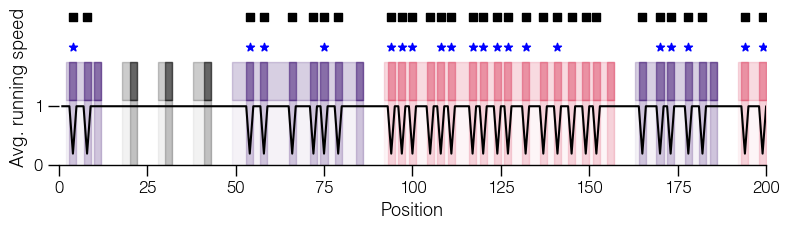

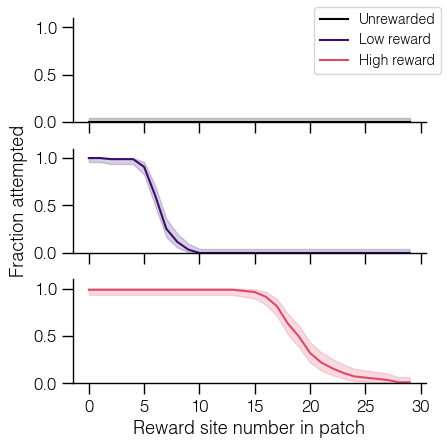

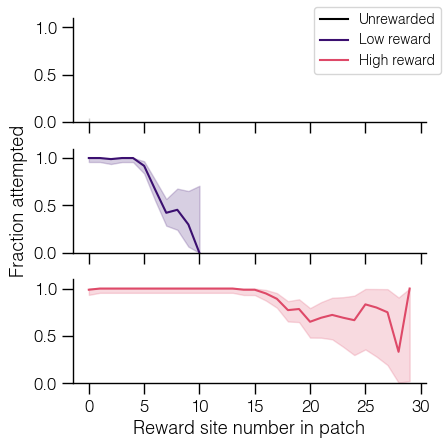

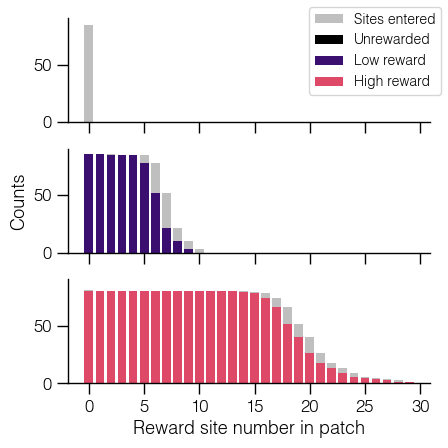

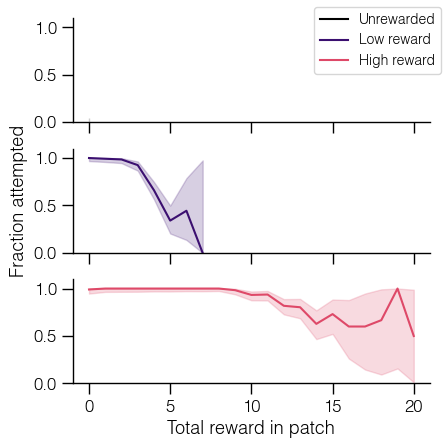

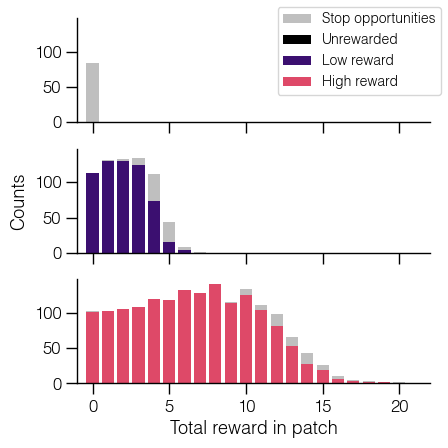

In [28]:
plot_session(
    '../../results/rl_agent_outputs/train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/state',
    env_idx=1,
    xlim=(0, 200),
    max_reward_param=50,
    max_reward_sites=30,
)

['00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']
Patch count: 27
(2, 30)
(2, 30)
(2, 30)
(2, 30)
(2, 30)
(2, 30)
(2, 40)
(2, 40)
(2, 40)
[ 0. 10. 30.]


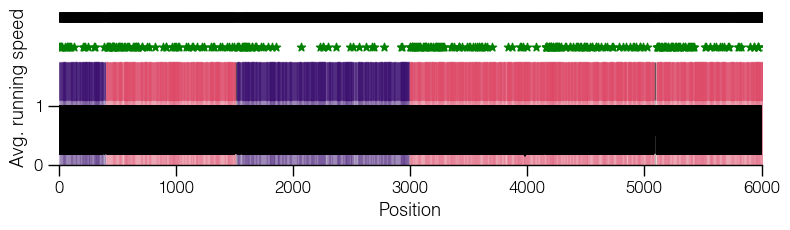

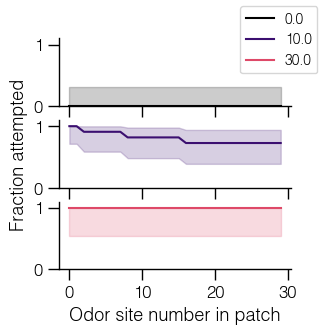

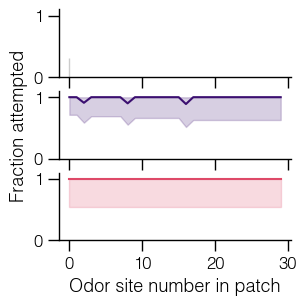

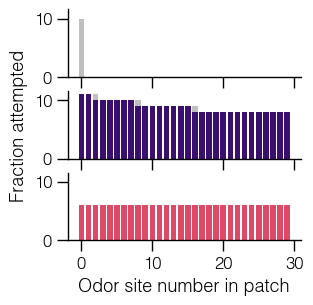

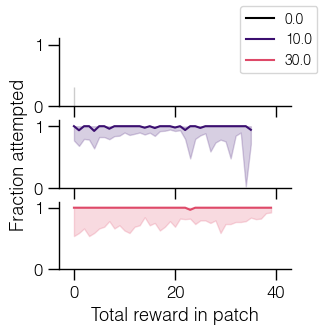

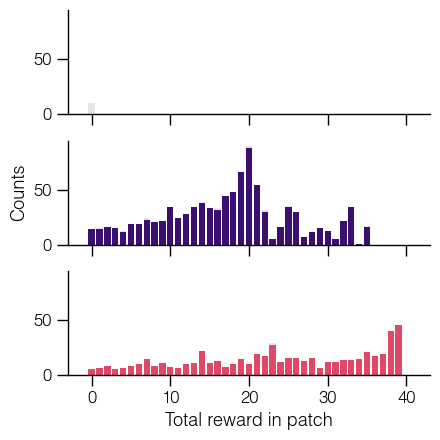

In [48]:
plot_session(
    '../../results/rl_agent_outputs/testing_network_trained_with_integrator_with_resets_ablated_int_output_2025-03-05_23_20_41_764597_var_noise_0_activity_weight_0/state',
    env_idx=1,
    xlim=(0, 6000),
    max_reward_param=50,
    max_reward_sites=30,
)

['00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']


C:\Users\david.bell\AppData\Local\Temp\ipykernel_28620\1483178862.py:15: RuntimeWarning: divide by zero encountered in divide
  axs.plot(np.arange(len(b_data['all_dwell_times'])), 1/np.array(b_data['all_dwell_times']), c='black', zorder=0)


Patch count: 12
(2, 30)
(2, 30)
(2, 30)
(2, 30)
(2, 30)
(2, 30)
(2, 40)
(2, 40)
(2, 40)
[ 0. 10. 30.]


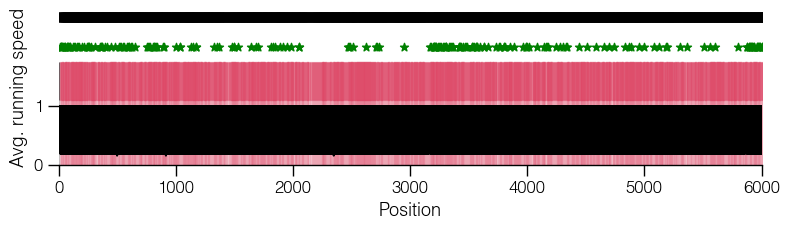

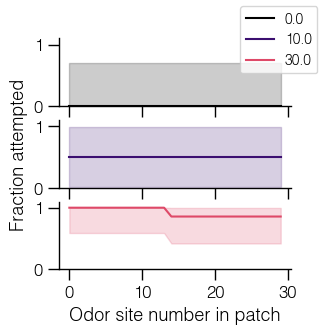

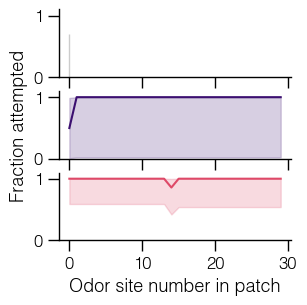

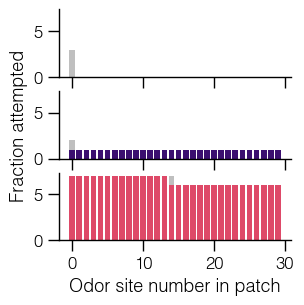

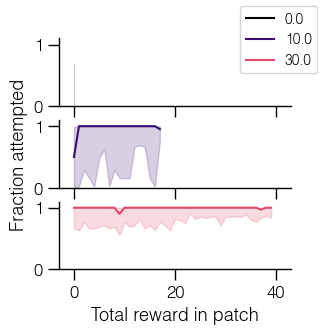

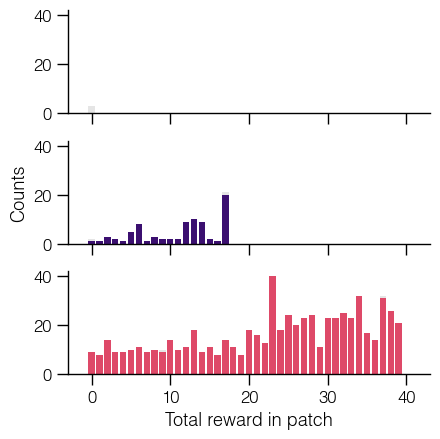

In [49]:
plot_session(
    '../../results/rl_agent_outputs/testing_network_trained_with_integrator_with_resets_ablated_int_output_2025-03-05_23_20_41_764597_var_noise_0_activity_weight_0/state',
    env_idx=0,
    xlim=(0, 6000),
    max_reward_param=50,
    max_reward_sites=30,
)

['00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']


C:\Users\david.bell\AppData\Local\Temp\ipykernel_23096\3702357192.py:15: RuntimeWarning: divide by zero encountered in divide
  axs.plot(np.arange(len(b_data['all_dwell_times'])), 1/np.array(b_data['all_dwell_times']), c='black', zorder=0)


Patch count: 25
[ 0. 10. 30.]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_23096\3702357192.py:103: RuntimeWarning: invalid value encountered in divide
  axs[k].bar(x, acc_reward_stops_for_patch_type[k, :] / acc_reward_stop_opportunities_for_patch_type[k, :], color=c)


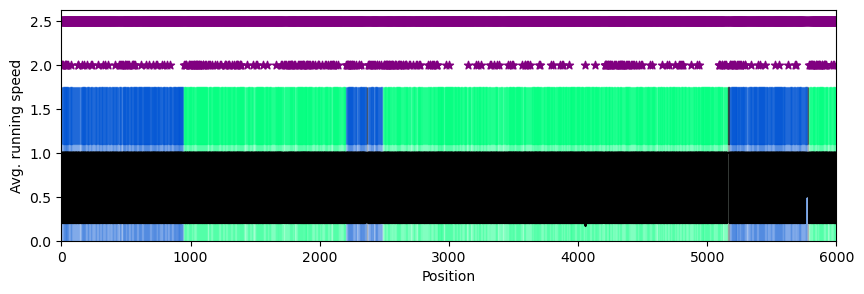

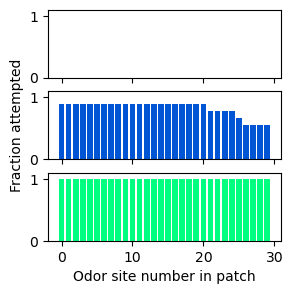

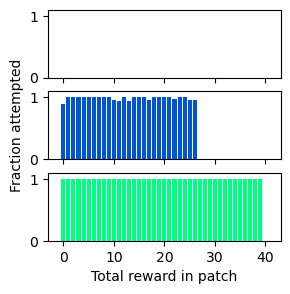

In [38]:
plot_session(
    '../../results/rl_agent_outputs/testing_network_trained_with_integrator_with_resets_ablated_int_output_2025-03-05_23_20_41_764597_var_noise_0_activity_weight_0/state',
    env_idx=2,
    xlim=(0, 6000),
    max_reward_param=30,
    max_reward_sites=30,
)

['00001.pkl', '00002.pkl']


C:\Users\david.bell\AppData\Local\Temp\ipykernel_23096\3702357192.py:15: RuntimeWarning: divide by zero encountered in divide
  axs.plot(np.arange(len(b_data['all_dwell_times'])), 1/np.array(b_data['all_dwell_times']), c='black', zorder=0)


Patch count: 12
[ 0. 10. 30.]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_23096\3702357192.py:103: RuntimeWarning: invalid value encountered in divide
  axs[k].bar(x, acc_reward_stops_for_patch_type[k, :] / acc_reward_stop_opportunities_for_patch_type[k, :], color=c)


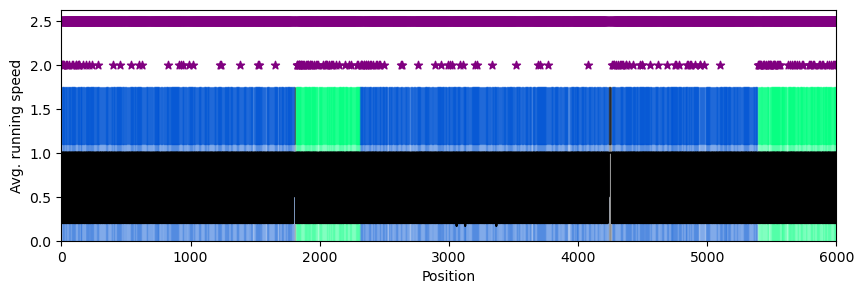

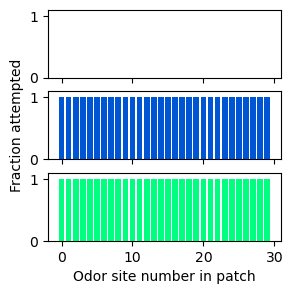

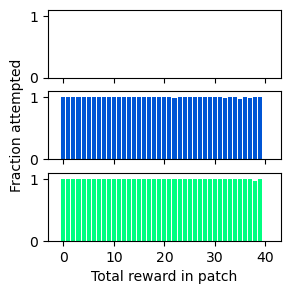

In [50]:
plot_sesson(
    '../../results/rl_agent_outputs/testing_network_trained_with_integrator_with_resets_atten_first_sub_pc_2025-03-06_00_14_38_874788_var_noise_0_activity_weight_0/state',
    env_idx=1,
    xlim=(0, 6000),
    max_reward_param=30,
    max_reward_sites=30,
)

['00001.pkl']


C:\Users\david.bell\AppData\Local\Temp\ipykernel_23096\3702357192.py:15: RuntimeWarning: divide by zero encountered in divide
  axs.plot(np.arange(len(b_data['all_dwell_times'])), 1/np.array(b_data['all_dwell_times']), c='black', zorder=0)


Patch count: 458
[ 0. 10. 30.]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_23096\3702357192.py:103: RuntimeWarning: invalid value encountered in divide
  axs[k].bar(x, acc_reward_stops_for_patch_type[k, :] / acc_reward_stop_opportunities_for_patch_type[k, :], color=c)


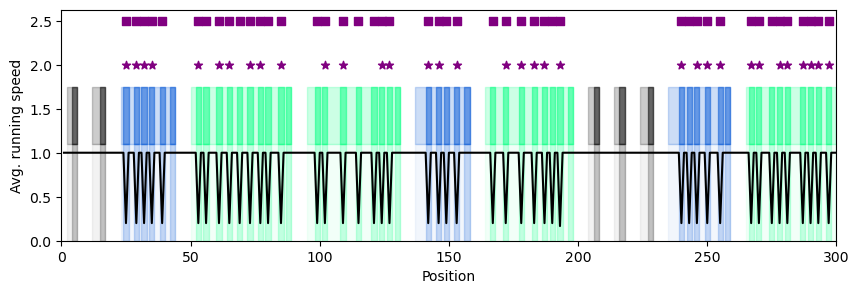

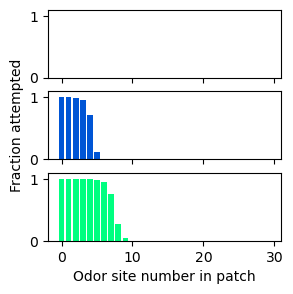

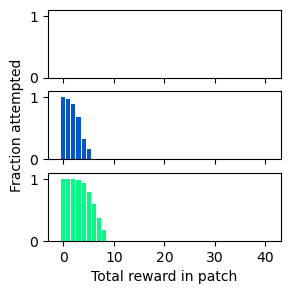

In [54]:
plot_sesson(
    '../../results/rl_agent_outputs/testing_network_trained_with_integrator_with_resets_amp_2p5p_first_sub_pc_2025-03-06_00_59_51_965734_var_noise_0_activity_weight_0/state',
    env_idx=0,
    xlim=(0, 300),
    max_reward_param=30,
    max_reward_sites=30,
)

['00001.pkl']


C:\Users\david.bell\AppData\Local\Temp\ipykernel_23096\3702357192.py:15: RuntimeWarning: divide by zero encountered in divide
  axs.plot(np.arange(len(b_data['all_dwell_times'])), 1/np.array(b_data['all_dwell_times']), c='black', zorder=0)


Patch count: 616
[ 0. 10. 30.]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_23096\3702357192.py:103: RuntimeWarning: invalid value encountered in divide
  axs[k].bar(x, acc_reward_stops_for_patch_type[k, :] / acc_reward_stop_opportunities_for_patch_type[k, :], color=c)


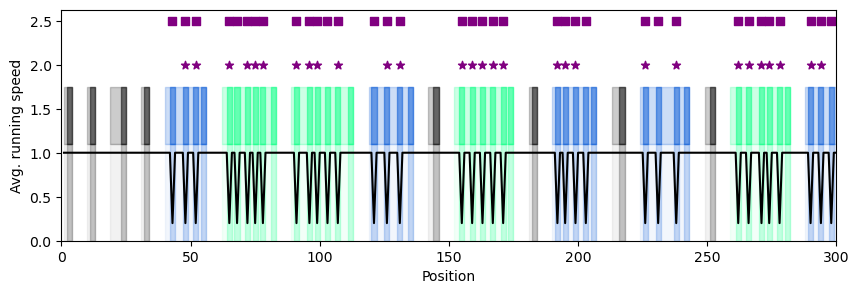

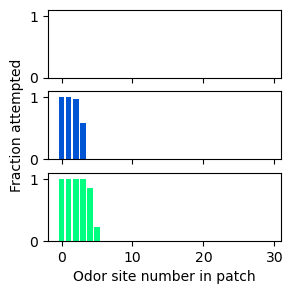

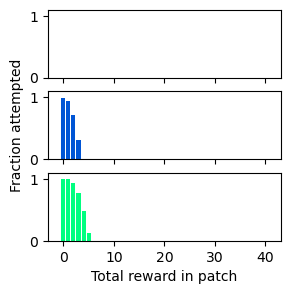

In [48]:
plot_sesson(
    '../../results/rl_agent_outputs/testing_network_trained_with_integrator_with_resets_amp_5p_first_sub_pc_2025-03-06_00_46_06_995369_var_noise_0_activity_weight_0/state',
    env_idx=0,
    xlim=(0, 300),
    max_reward_param=30,
    max_reward_sites=30,
)

['00001.pkl']


C:\Users\david.bell\AppData\Local\Temp\ipykernel_23096\3702357192.py:15: RuntimeWarning: divide by zero encountered in divide
  axs.plot(np.arange(len(b_data['all_dwell_times'])), 1/np.array(b_data['all_dwell_times']), c='black', zorder=0)


Patch count: 847
[ 0. 10. 30.]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_23096\3702357192.py:103: RuntimeWarning: invalid value encountered in divide
  axs[k].bar(x, acc_reward_stops_for_patch_type[k, :] / acc_reward_stop_opportunities_for_patch_type[k, :], color=c)


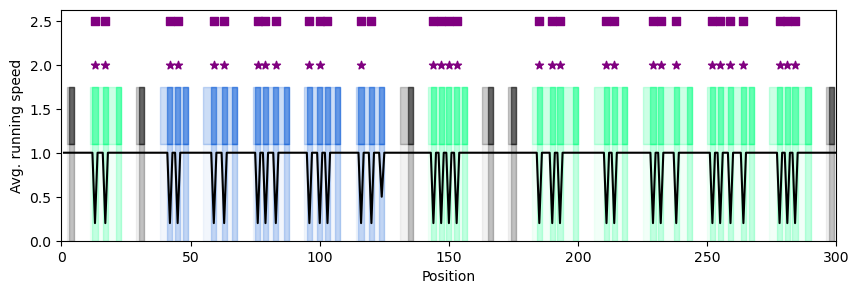

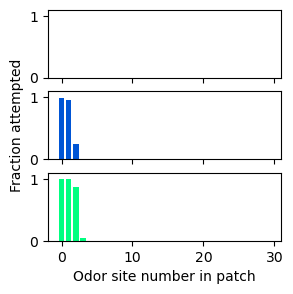

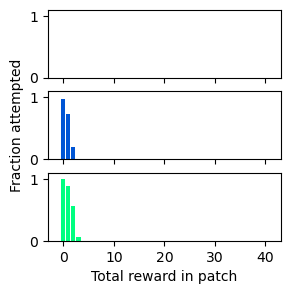

In [53]:
plot_sesson(
    '../../results/rl_agent_outputs/testing_network_trained_with_integrator_with_resets_amp_10p_first_sub_pc_2025-03-06_00_48_44_802826_var_noise_0_activity_weight_0/state',
    env_idx=0,
    xlim=(0, 300),
    max_reward_param=30,
    max_reward_sites=30,
)

['00001.pkl']


C:\Users\david.bell\AppData\Local\Temp\ipykernel_23096\3702357192.py:15: RuntimeWarning: divide by zero encountered in divide
  axs.plot(np.arange(len(b_data['all_dwell_times'])), 1/np.array(b_data['all_dwell_times']), c='black', zorder=0)


Patch count: 183
[ 0. 10. 30.]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_23096\3702357192.py:103: RuntimeWarning: invalid value encountered in divide
  axs[k].bar(x, acc_reward_stops_for_patch_type[k, :] / acc_reward_stop_opportunities_for_patch_type[k, :], color=c)


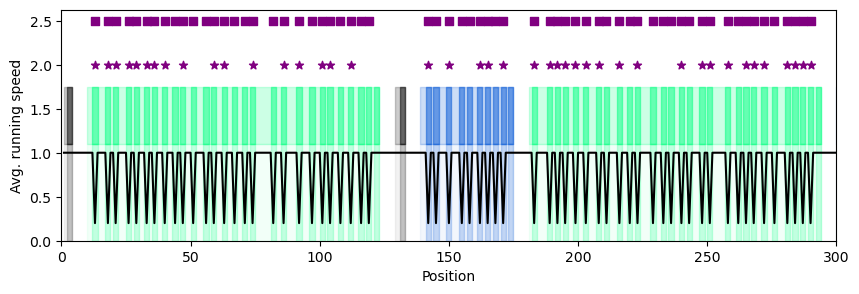

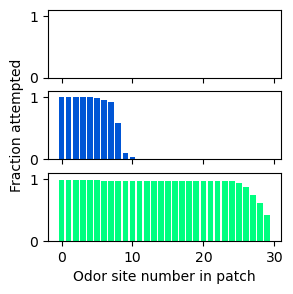

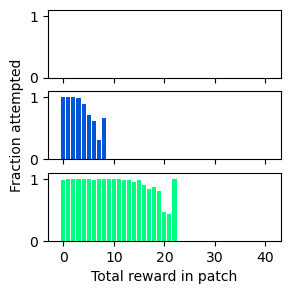

In [59]:
plot_sesson(
    '../../results/rl_agent_outputs/testing_network_trained_with_integrator_with_resets_atten_0p5p_first_sub_pc_2025-03-06_01_13_40_935005_var_noise_0_activity_weight_0/state',
    env_idx=0,
    xlim=(0, 300),
    max_reward_param=30,
    max_reward_sites=30,
)

['00001.pkl', '00002.pkl']


C:\Users\david.bell\AppData\Local\Temp\ipykernel_23096\3702357192.py:15: RuntimeWarning: divide by zero encountered in divide
  axs.plot(np.arange(len(b_data['all_dwell_times'])), 1/np.array(b_data['all_dwell_times']), c='black', zorder=0)


Patch count: 80
[ 0. 10. 30.]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_23096\3702357192.py:103: RuntimeWarning: invalid value encountered in divide
  axs[k].bar(x, acc_reward_stops_for_patch_type[k, :] / acc_reward_stop_opportunities_for_patch_type[k, :], color=c)


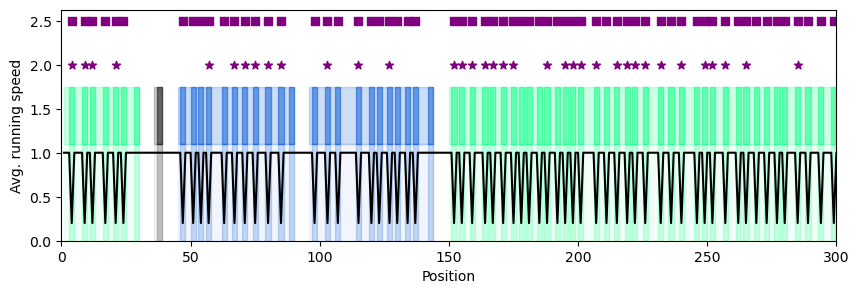

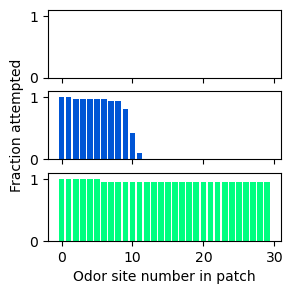

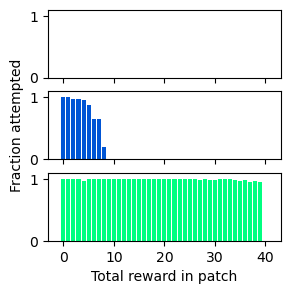

In [56]:
plot_sesson(
    '../../results/rl_agent_outputs/testing_network_trained_with_integrator_with_resets_atten_1p_first_sub_pc_2025-03-06_01_09_55_874529_var_noise_0_activity_weight_0/state',
    env_idx=0,
    xlim=(0, 300),
    max_reward_param=30,
    max_reward_sites=30,
)

['00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl']


C:\Users\david.bell\AppData\Local\Temp\ipykernel_23096\3702357192.py:15: RuntimeWarning: divide by zero encountered in divide
  axs.plot(np.arange(len(b_data['all_dwell_times'])), 1/np.array(b_data['all_dwell_times']), c='black', zorder=0)


Patch count: 11
[ 0. 10. 30.]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_23096\3702357192.py:103: RuntimeWarning: invalid value encountered in divide
  axs[k].bar(x, acc_reward_stops_for_patch_type[k, :] / acc_reward_stop_opportunities_for_patch_type[k, :], color=c)


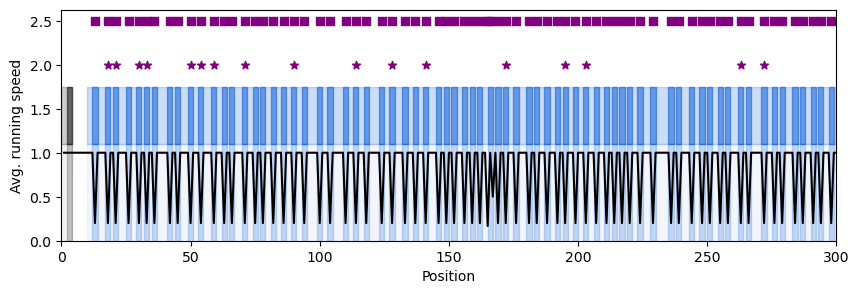

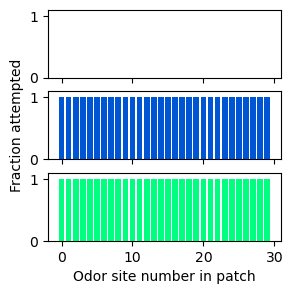

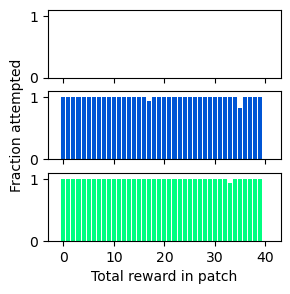

In [57]:
plot_sesson(
    '../../results/rl_agent_outputs/testing_network_trained_with_integrator_with_resets_atten_5p_first_sub_pc_2025-03-06_01_08_17_339572_var_noise_0_activity_weight_0/state',
    env_idx=0,
    xlim=(0, 300),
    max_reward_param=30,
    max_reward_sites=30,
)

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl']


C:\Users\david.bell\AppData\Local\Temp\ipykernel_29828\3702357192.py:15: RuntimeWarning: divide by zero encountered in divide
  axs.plot(np.arange(len(b_data['all_dwell_times'])), 1/np.array(b_data['all_dwell_times']), c='black', zorder=0)


Patch count: 251
[ 0. 10. 30.]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_29828\3702357192.py:103: RuntimeWarning: invalid value encountered in divide
  axs[k].bar(x, acc_reward_stops_for_patch_type[k, :] / acc_reward_stop_opportunities_for_patch_type[k, :], color=c)


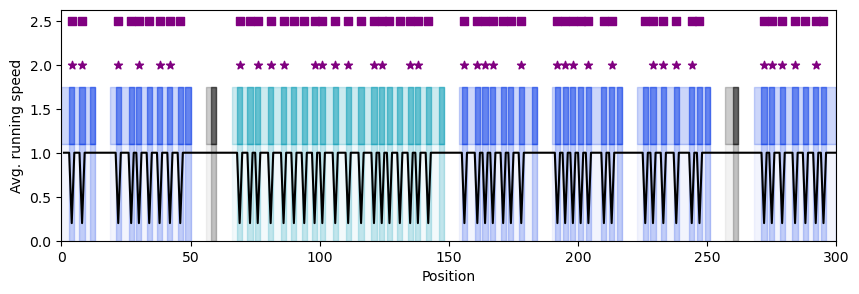

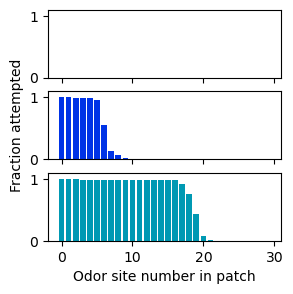

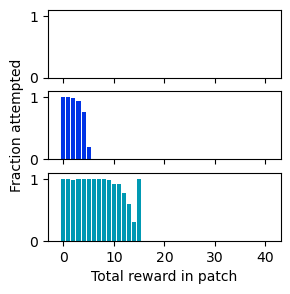

In [5]:
plot_sesson(
    '../../results/rl_agent_outputs/test_augment_pretrain_2025-03-21_13_41_00_398273_var_noise_0_activity_weight_0_sn_02000/state',
    env_idx=1,
    xlim=(0, 300),
    max_reward_param=50,
    max_reward_sites=30,
)

['00000.pkl']


C:\Users\david.bell\AppData\Local\Temp\ipykernel_29828\3702357192.py:15: RuntimeWarning: divide by zero encountered in divide
  axs.plot(np.arange(len(b_data['all_dwell_times'])), 1/np.array(b_data['all_dwell_times']), c='black', zorder=0)


Patch count: 264
[ 0. 50. 50.]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_29828\3702357192.py:103: RuntimeWarning: invalid value encountered in divide
  axs[k].bar(x, acc_reward_stops_for_patch_type[k, :] / acc_reward_stop_opportunities_for_patch_type[k, :], color=c)


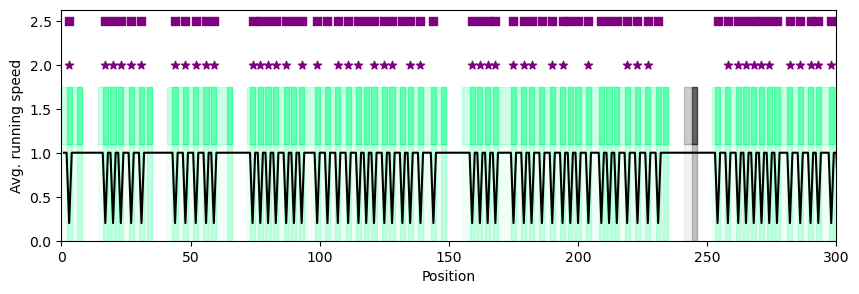

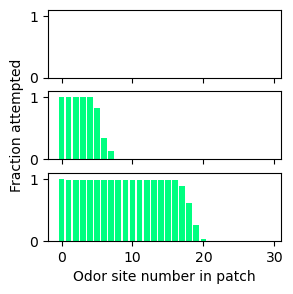

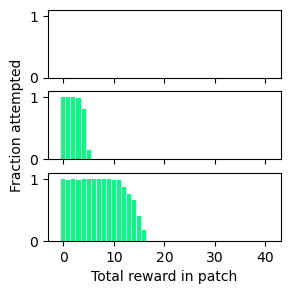

In [6]:
plot_sesson(
    '../../results/rl_agent_outputs/test_augment_pretrain_extra_reward_50_50_2025-03-22_11_03_02_067067_var_noise_0_activity_weight_0_sn_02000/state',
    env_idx=1,
    xlim=(0, 300),
    max_reward_param=50,
    max_reward_sites=30,
)

['00000.pkl', '00001.pkl', '00002.pkl']


C:\Users\david.bell\AppData\Local\Temp\ipykernel_29828\3702357192.py:15: RuntimeWarning: divide by zero encountered in divide
  axs.plot(np.arange(len(b_data['all_dwell_times'])), 1/np.array(b_data['all_dwell_times']), c='black', zorder=0)


Patch count: 304


C:\Users\david.bell\AppData\Local\Temp\ipykernel_29828\3702357192.py:103: RuntimeWarning: invalid value encountered in divide
  axs[k].bar(x, acc_reward_stops_for_patch_type[k, :] / acc_reward_stop_opportunities_for_patch_type[k, :], color=c)


[ 0. 50. 50.]


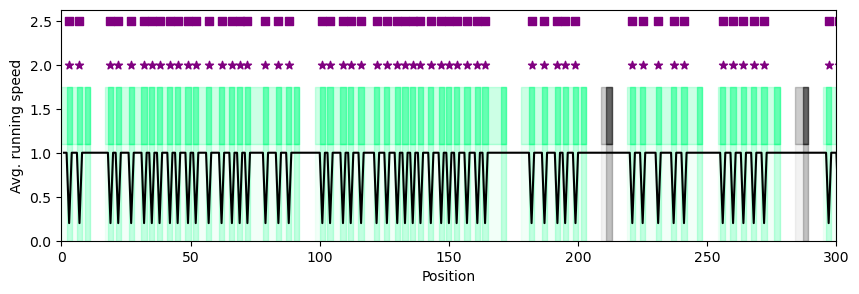

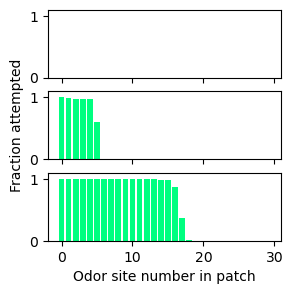

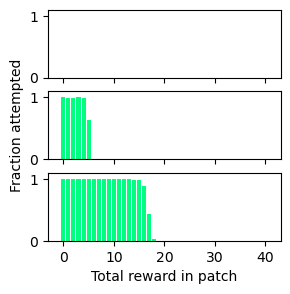

In [8]:
plot_sesson(
    '../../results/rl_agent_outputs/test_augment_pretrain_extra_reward_det_2025-03-22_11_10_32_440638_var_noise_0_activity_weight_0_sn_02000/state',
    env_idx=0,
    xlim=(0, 300),
    max_reward_param=50,
    max_reward_sites=30,
)

In [13]:
def plot_avg_stops_vs_reward_param(data_paths, update_num=None, max_reward_param=10, max_reward_sites=30, model_colors=None):

    cmap = mpl.colormaps['winter']
    if model_colors is None:
        model_colors = ['purple', 'green']

    scale = 1
    fig_sensitivity, axs_sensitivity = plt.subplots(6, 5, figsize=(8 * scale, 6 * scale), sharex=True, sharey=True)

    for idx_data_path, data_path in enumerate(data_paths):

        d = load_behavioral_data(data_path, update_num).__next__()
    
        for env_idx in range(30):
            b_data = parse_behavioral_data(d, env_idx)
            rewards_at_positions = b_data['rewards_at_positions']
            reward_attempted_at_positions = b_data['reward_attempted_at_positions']
            all_patch_nums = b_data['current_patch_num']
            all_patch_reward_params = b_data['patch_reward_param']
            
            reward_param_of_stop = []
            site_idx_of_stop =  []
            site_stops_for_patch_type = np.zeros((np.array(all_patch_nums).max() + 1, max_reward_sites))
            patches_entered_for_patch_type = np.zeros((np.array(all_patch_nums).max() + 1,))
            reward_param_for_patch_type = np.zeros((np.array(all_patch_nums).max() + 1,))
            
            last_pstart = None
            last_reward_site_start = None
            patch_count = 0
            for i, pstart in enumerate(b_data['current_patch_start']):
                # print(f'Step {i}')
                if last_pstart is None or (pstart != last_pstart).any():
                    patches_entered_for_patch_type[all_patch_nums[i]] += 1
                    reward_param_for_patch_type[all_patch_nums[i]] = all_patch_reward_params[i]
                    patch_count += 1
                    pb = [pstart, pstart]
                    rw_site_counter = 0
                
                rwsb = copy(b_data['reward_bounds'][i])
                reward_site_start = int(rwsb[0])
                # print('rwsite_start', reward_site_start)
                # print('last_rwsite_start', last_reward_site_start)
                if last_reward_site_start is None or last_reward_site_start != reward_site_start:
                    if np.sum(reward_attempted_at_positions[int(rwsb[0]):int(rwsb[1])]) == 0:
                        pb[1] = rwsb[1]
                    else:
                        reward_param_of_stop.append(b_data['patch_reward_param'][i])
                        site_idx_of_stop.append(rw_site_counter)
                        if rw_site_counter < max_reward_sites:
                            site_stops_for_patch_type[all_patch_nums[i], rw_site_counter] += 1
                        rw_site_counter += 1
        
                last_pstart = pstart
                last_reward_site_start = reward_site_start
            
            print(reward_param_for_patch_type)
    
            scale = 1
            fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)
            # mx = site_stops_for_patch_type.max()
    
            avg_stops_for_patch_type = np.empty((site_stops_for_patch_type.shape[0],))
            
            x = np.arange(1, site_stops_for_patch_type.shape[1] + 1)
            for k in range(site_stops_for_patch_type.shape[0]):
                cdf = site_stops_for_patch_type[k, :] / patches_entered_for_patch_type[k]
                c = cmap(reward_param_for_patch_type[k] / max_reward_param) if reward_param_for_patch_type[k] > 0 else 'black'
                axs[k].bar(x, cdf, color=c)
                axs[k].set_ylim(0, 1.1)
    
                pdf = cdf - np.concatenate([cdf[1:], np.zeros(1)])
                # axs[k].bar(x, pdf, color=cmap(reward_param_for_patch_type[k] / max_reward_param))
    
                avg_stops_for_patch_type[k] = np.dot(pdf, x)
    
            axs[1].set_ylabel('Fraction attempted')
            axs[2].set_xlabel('Odor site number in patch')
    
            ordering = np.argsort(reward_param_for_patch_type)
    
            axs_sensitivity[int(env_idx / 5), env_idx % 5].plot(reward_param_for_patch_type[ordering], avg_stops_for_patch_type[ordering], c=model_colors[idx_data_path])
            axs_sensitivity[int(env_idx / 5), env_idx % 5].scatter(reward_param_for_patch_type, avg_stops_for_patch_type, c=model_colors[idx_data_path])
        
    axs_sensitivity[0, 0].set_ylim(0, 30)
    axs_sensitivity[0, 0].set_xlim(0, max_reward_param * 1.1)
    axs_sensitivity[1, 0].set_ylabel('Avg number of stops')
    axs_sensitivity[-1, 2].set_xlabel('Reward decay parameter')
            
    

['00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_23096\1293315914.py:66: RuntimeWarning: invalid value encountered in divide
  cdf = site_stops_for_patch_type[k, :] / patches_entered_for_patch_type[k]


[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_23096\1293315914.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)


[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]


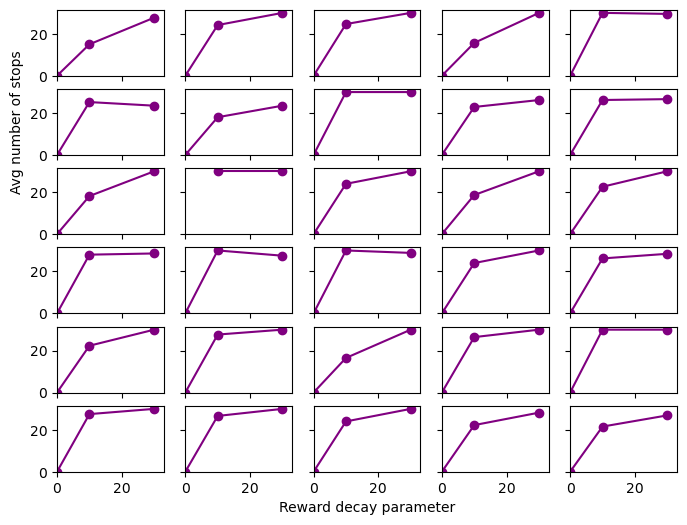

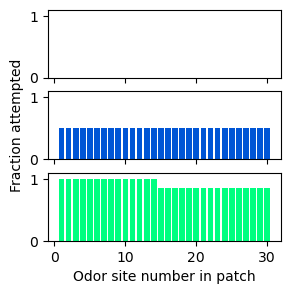

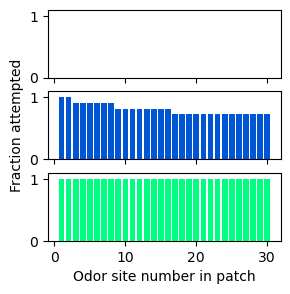

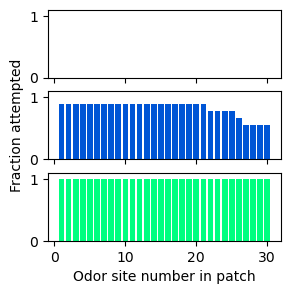

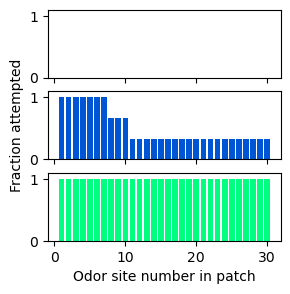

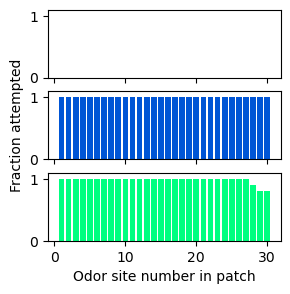

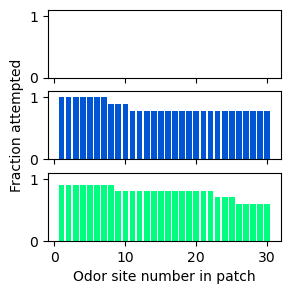

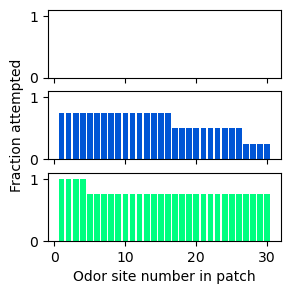

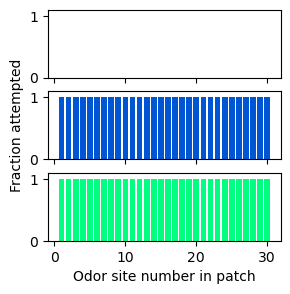

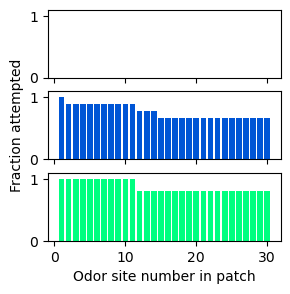

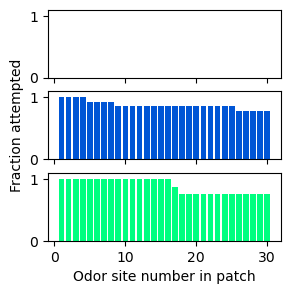

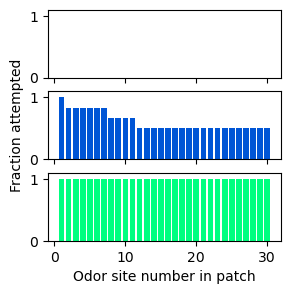

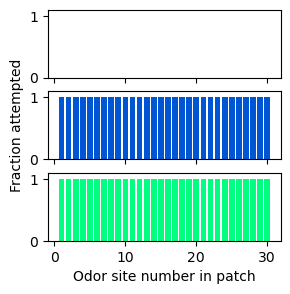

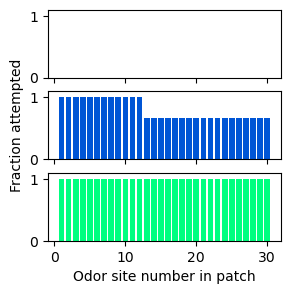

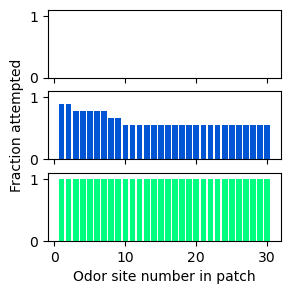

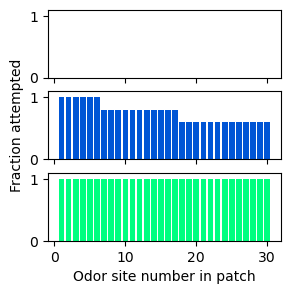

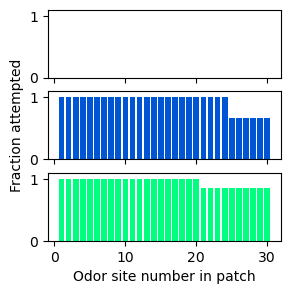

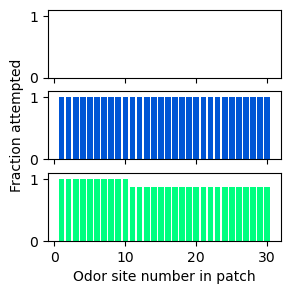

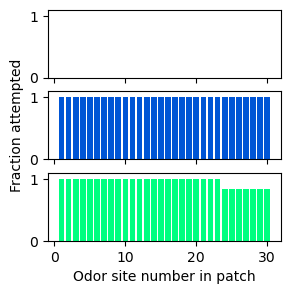

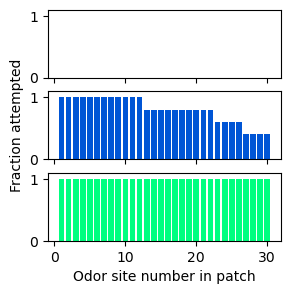

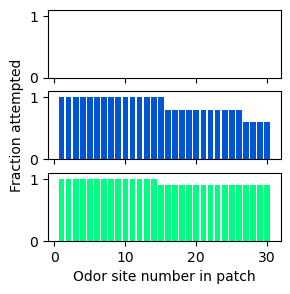

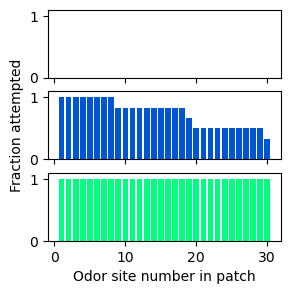

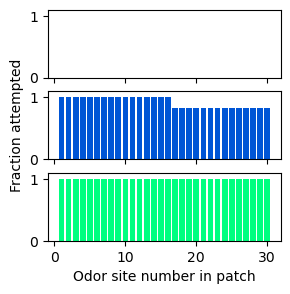

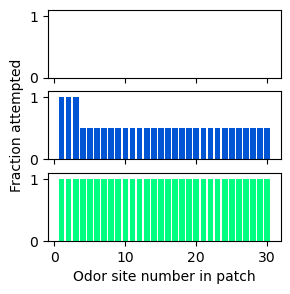

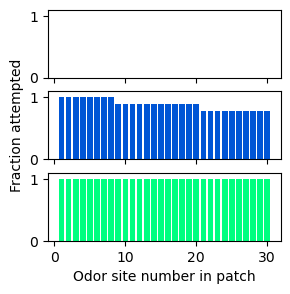

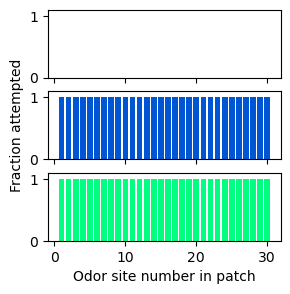

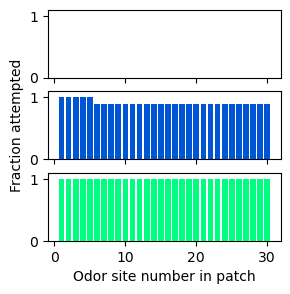

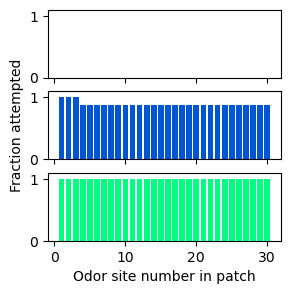

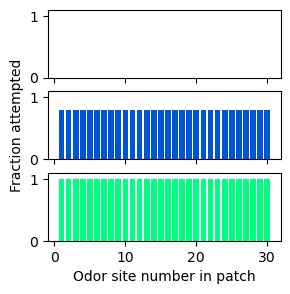

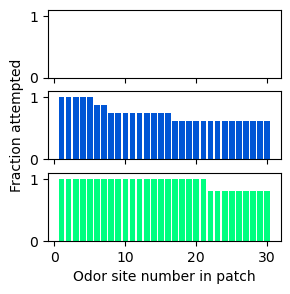

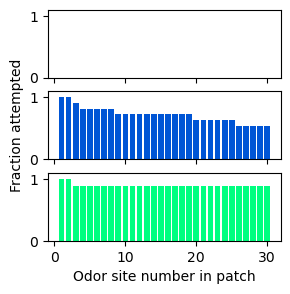

In [36]:
plot_avg_stops_vs_reward_param([
        '../../results/rl_agent_outputs/testing_network_trained_with_integrator_with_resets_ablated_int_output_2025-03-05_23_20_41_764597_var_noise_0_activity_weight_0/state',
    ],
    max_reward_param=30,
)

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl']
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_29828\3766762776.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)


[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]


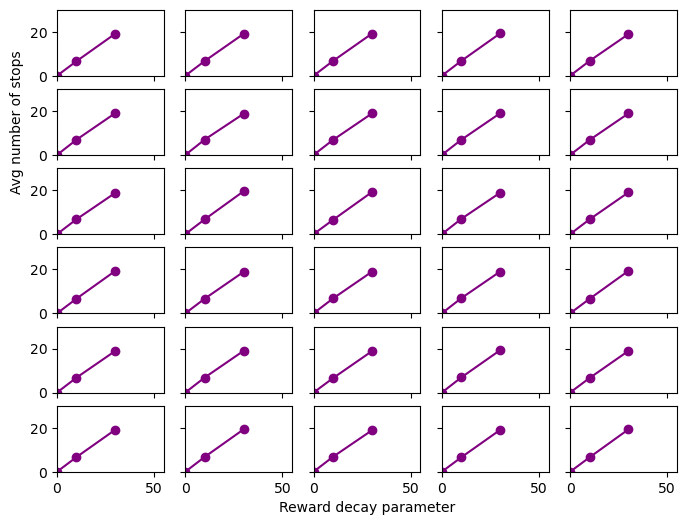

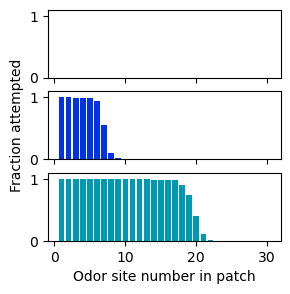

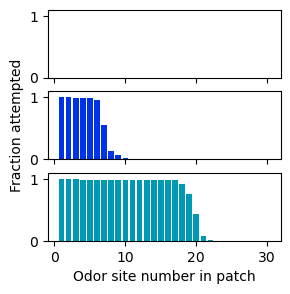

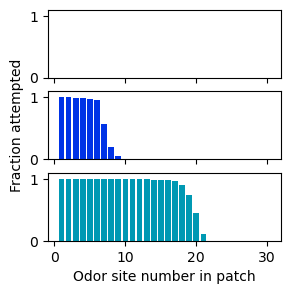

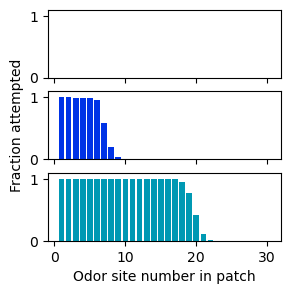

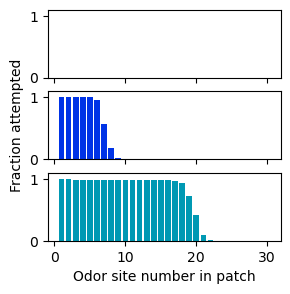

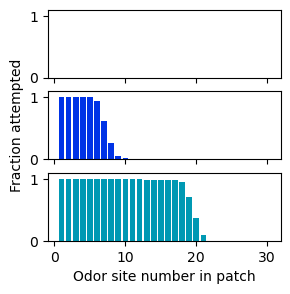

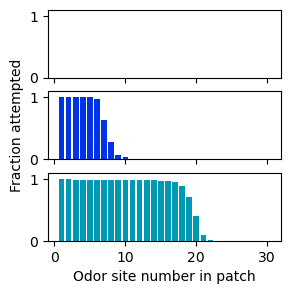

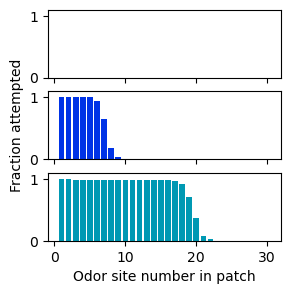

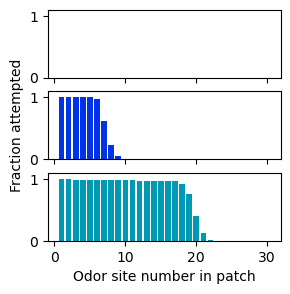

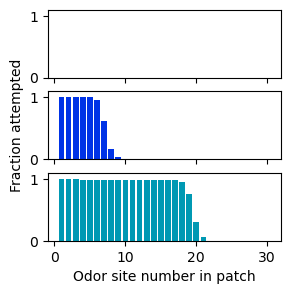

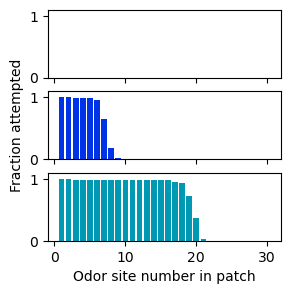

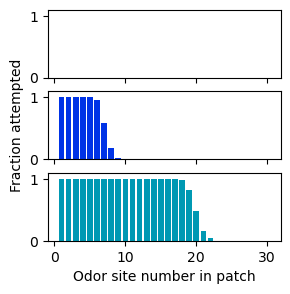

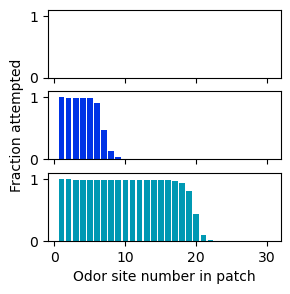

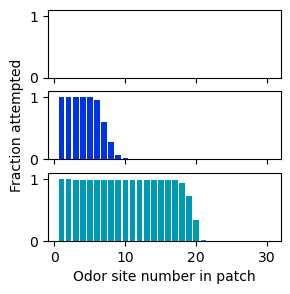

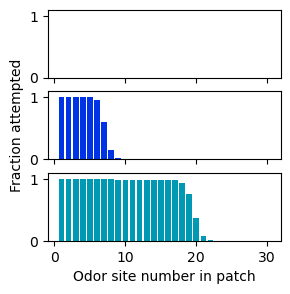

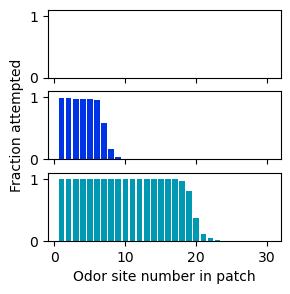

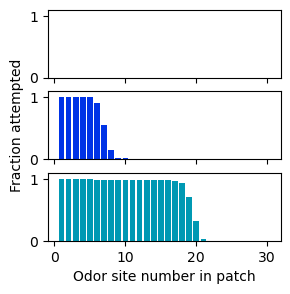

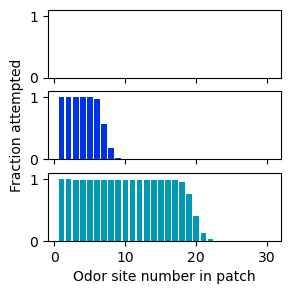

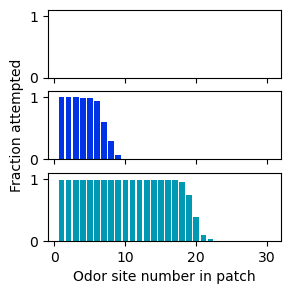

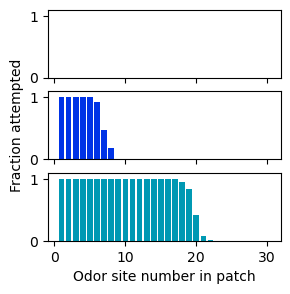

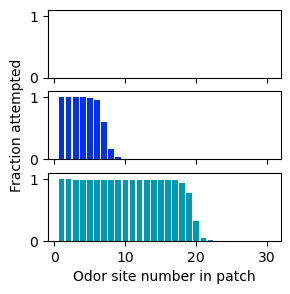

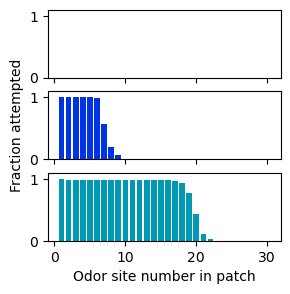

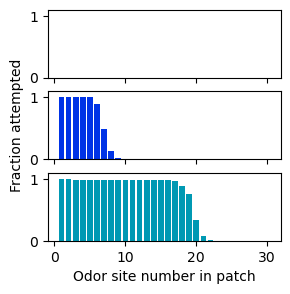

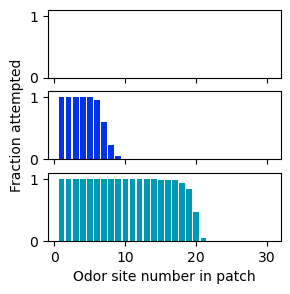

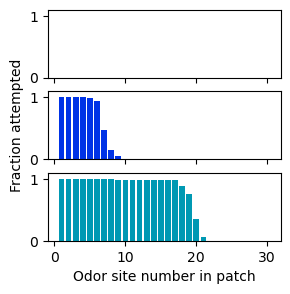

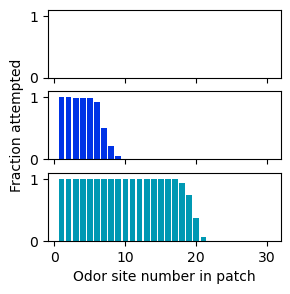

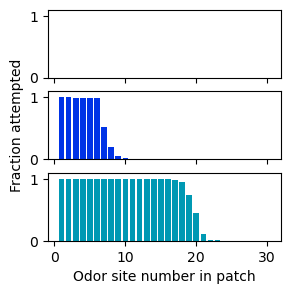

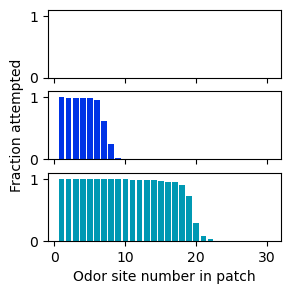

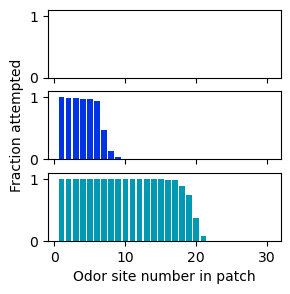

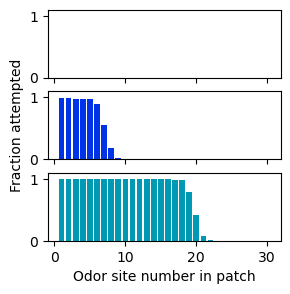

In [14]:
plot_avg_stops_vs_reward_param([
        '../../results/rl_agent_outputs/test_augment_pretrain_2025-03-21_13_41_00_398273_var_noise_0_activity_weight_0_sn_02000/state',
    ],
    max_reward_param=50,
)

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl']
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_29828\3766762776.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)


[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]


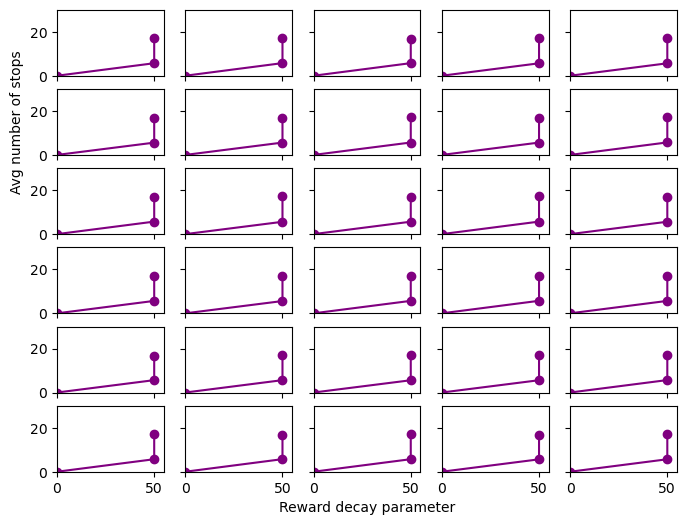

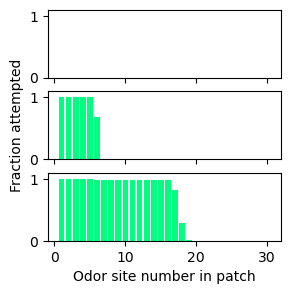

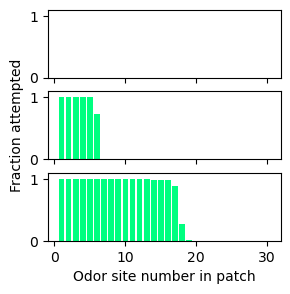

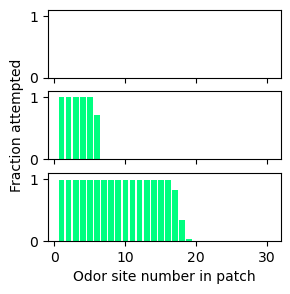

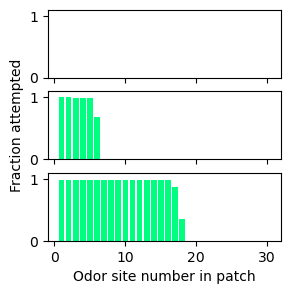

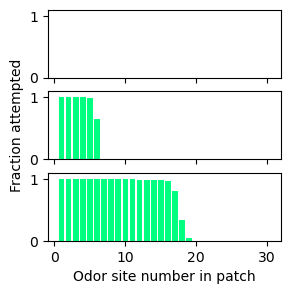

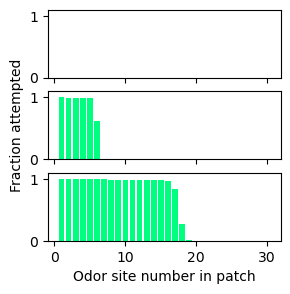

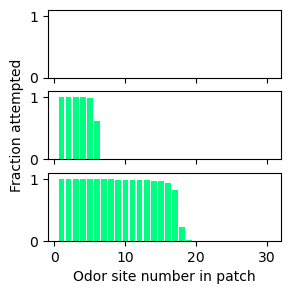

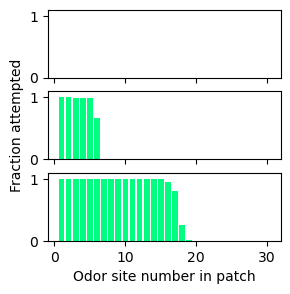

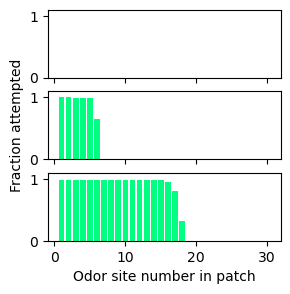

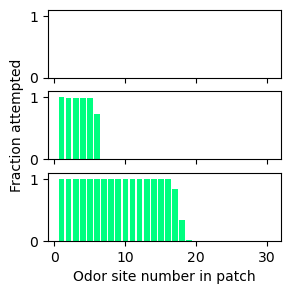

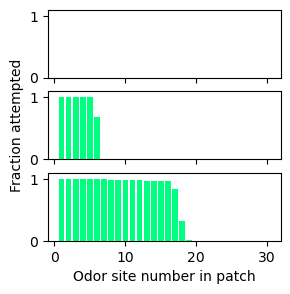

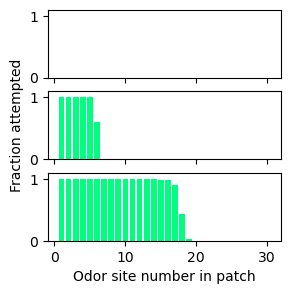

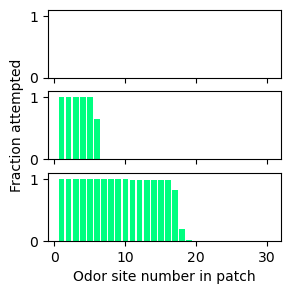

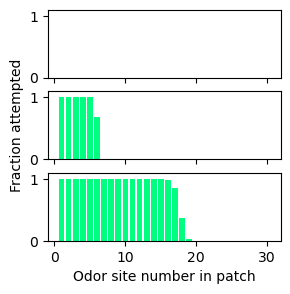

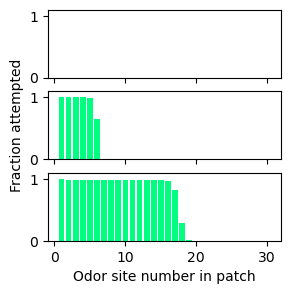

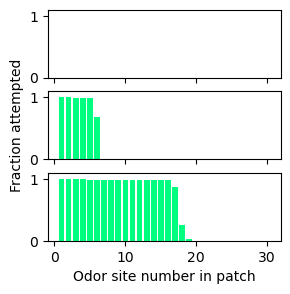

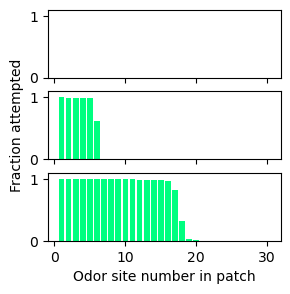

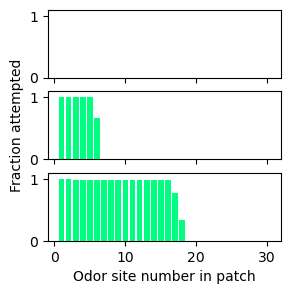

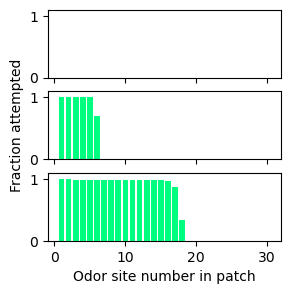

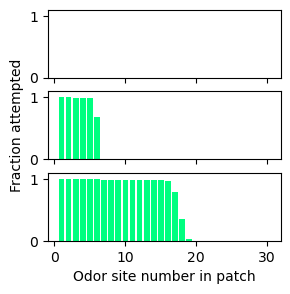

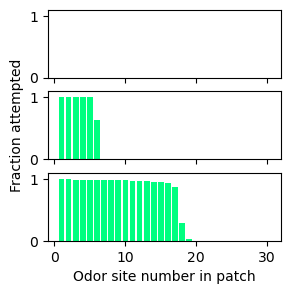

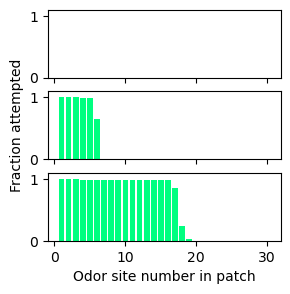

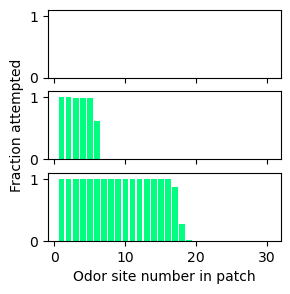

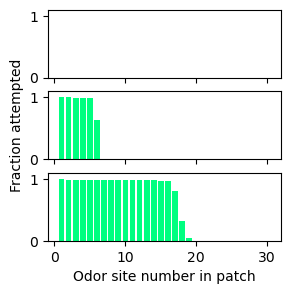

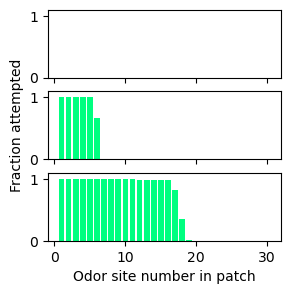

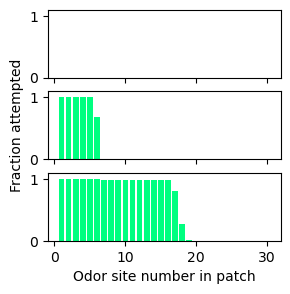

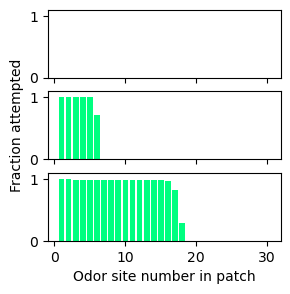

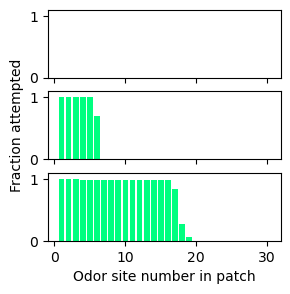

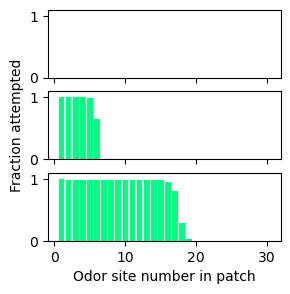

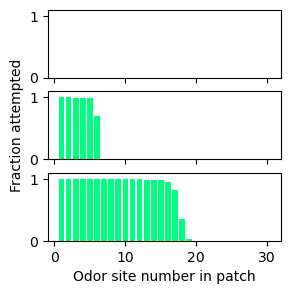

In [15]:
plot_avg_stops_vs_reward_param([
        '../../results/rl_agent_outputs/test_augment_pretrain_extra_reward_det_2025-03-22_11_10_32_440638_var_noise_0_activity_weight_0_sn_02000/state',
    ],
    max_reward_param=50,
)

['00000.pkl']
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_29828\3766762776.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)


[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]
[ 0. 50. 50.]


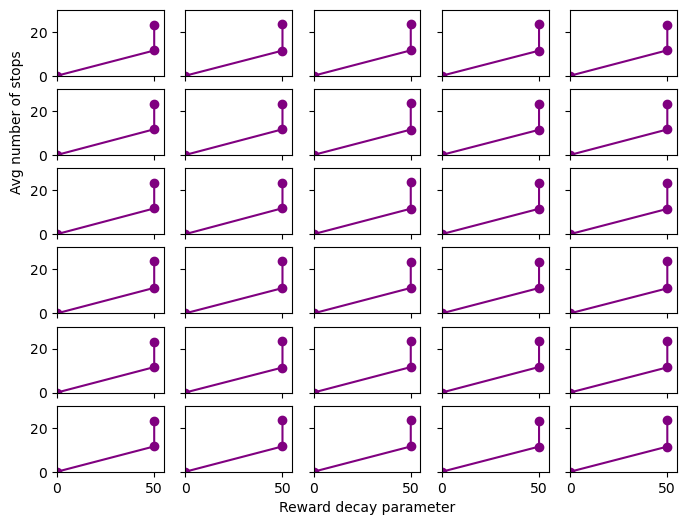

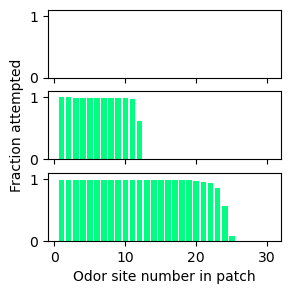

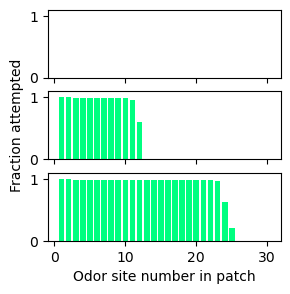

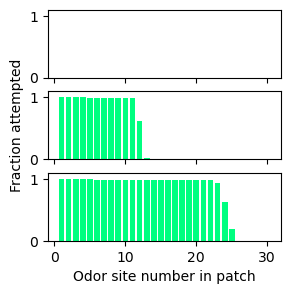

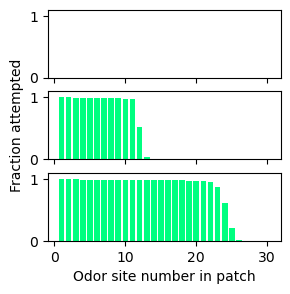

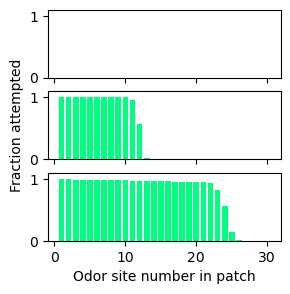

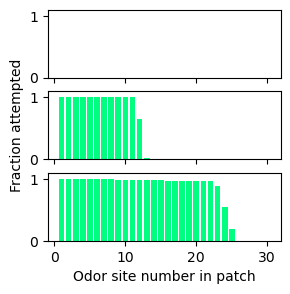

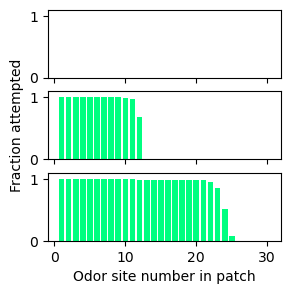

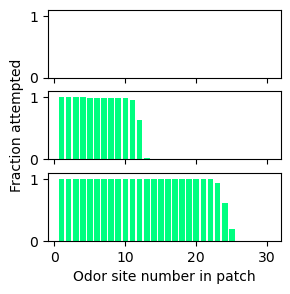

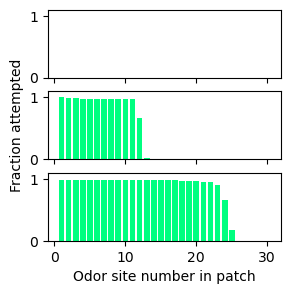

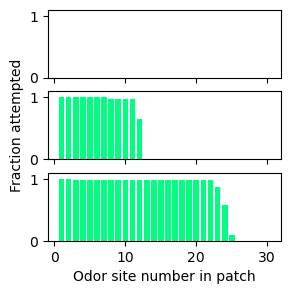

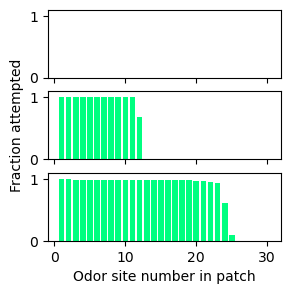

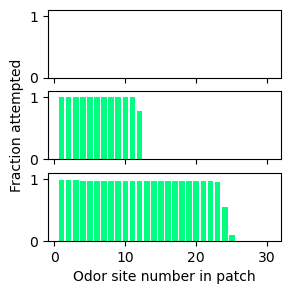

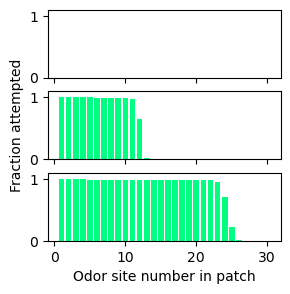

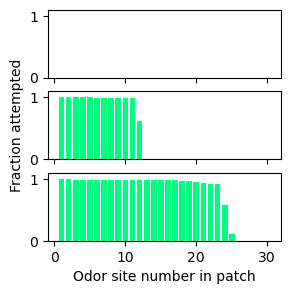

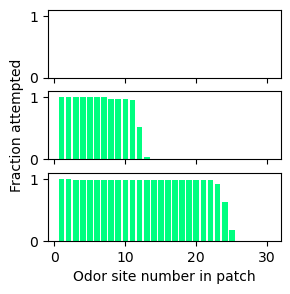

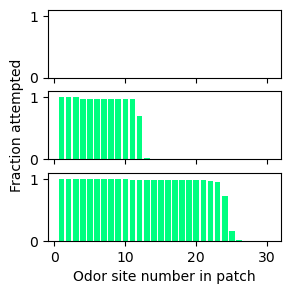

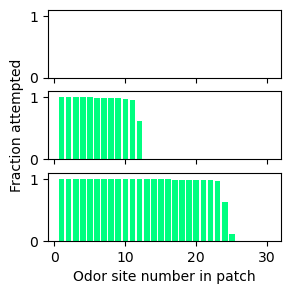

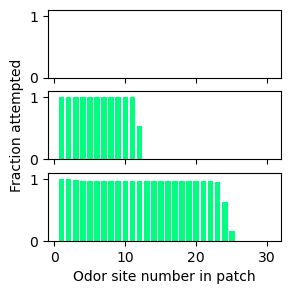

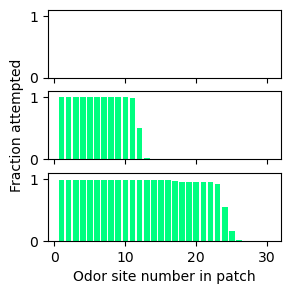

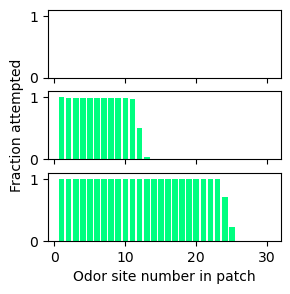

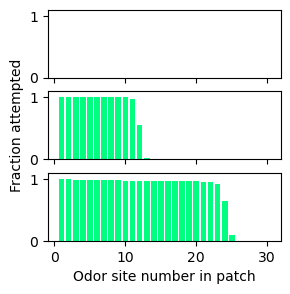

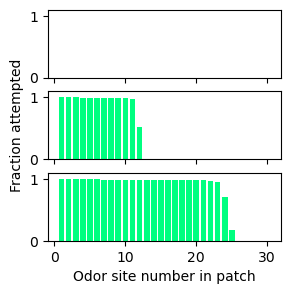

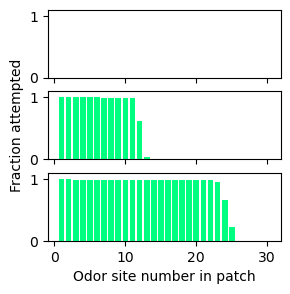

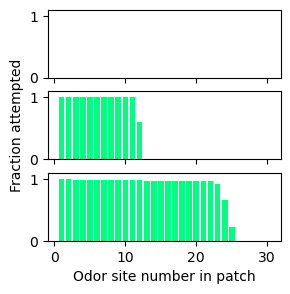

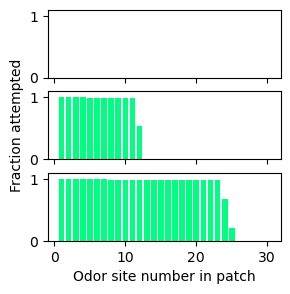

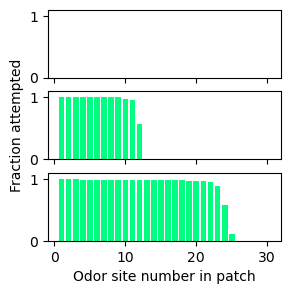

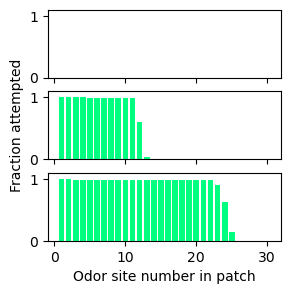

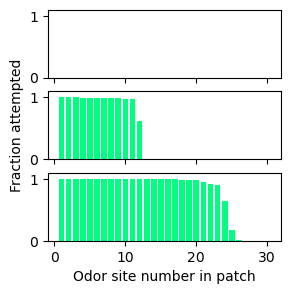

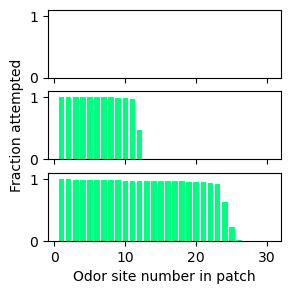

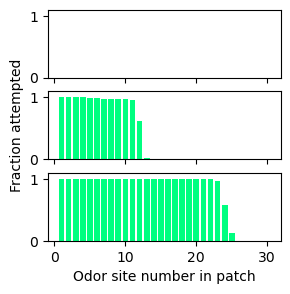

In [16]:
plot_avg_stops_vs_reward_param([
        '../../results/rl_agent_outputs/test_augment_pretrain_no_reward_2025-03-22_11_38_02_743224_var_noise_0_activity_weight_0_sn_02000/state',
    ],
    max_reward_param=50,
)

In [48]:
def plot_staying_probability_for_reward_site(data_paths, update_num=None, max_reward_param=10, max_reward_sites=30, model_colors=None):

    cmap = mpl.colormaps['winter']

    scale = 1.5
    fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 1 * scale), sharex=True, sharey=True)
    axs = [axs]

    for idx_data_path, data_path in enumerate(data_paths):

        d = load_behavioral_data(data_path, update_num)

        all_cdfs = np.empty((3, 30, max_reward_sites))
    
        for env_idx in range(30):
            b_data = parse_behavioral_data(d, env_idx)
            rewards_at_positions = b_data['rewards_at_positions']
            reward_attempted_at_positions = b_data['reward_attempted_at_positions']
            all_patch_nums = b_data['current_patch_num']
            all_patch_reward_params = b_data['patch_reward_param']
            
            reward_param_of_stop = []
            site_idx_of_stop =  []
            site_stops_for_patch_type = np.zeros((np.array(all_patch_nums).max() + 1, max_reward_sites))
            patches_entered_for_patch_type = np.zeros((np.array(all_patch_nums).max() + 1,))
            reward_param_for_patch_type = np.zeros((np.array(all_patch_nums).max() + 1,))
            
            last_pstart = None
            last_reward_site_start = None
            patch_count = 0
            for i, pstart in enumerate(b_data['current_patch_start']):
                # print(f'Step {i}')
                if last_pstart is None or (pstart != last_pstart).any():
                    patches_entered_for_patch_type[all_patch_nums[i]] += 1
                    reward_param_for_patch_type[all_patch_nums[i]] = all_patch_reward_params[i]
                    patch_count += 1
                    pb = [pstart, pstart]
                    rw_site_counter = 0
                
                rwsb = copy(b_data['reward_bounds'][i])
                reward_site_start = int(rwsb[0])
                # print('rwsite_start', reward_site_start)
                # print('last_rwsite_start', last_reward_site_start)
                if last_reward_site_start is None or last_reward_site_start != reward_site_start:
                    if np.sum(reward_attempted_at_positions[int(rwsb[0]):int(rwsb[1])]) == 0:
                        pb[1] = rwsb[1]
                    else:
                        reward_param_of_stop.append(b_data['patch_reward_param'][i])
                        site_idx_of_stop.append(rw_site_counter)
                        if rw_site_counter < max_reward_sites:
                            site_stops_for_patch_type[all_patch_nums[i], rw_site_counter] += 1
                        rw_site_counter += 1
        
                last_pstart = pstart
                last_reward_site_start = reward_site_start
    
            # mx = site_stops_for_patch_type.max()
    
            avg_stops_for_patch_type = np.empty((site_stops_for_patch_type.shape[0],))
            
            for k in range(site_stops_for_patch_type.shape[0]):
                cdf = site_stops_for_patch_type[k, :]
                cdf[1:] = cdf[1:] / cdf[0:-1]
                cdf[0] = cdf[0] / patches_entered_for_patch_type[k]

                all_cdfs[k, env_idx, :] = cdf
                # c = cmap(reward_param_for_patch_type[k] / max_reward_param) if reward_param_for_patch_type[k] > 0 else 'black'
                # axs[0].plot(x, cdf, color=c, lw=1)
                # axs[0].scatter(x, cdf, color=c, s=5)
                # axs[0].set_ylim(-0.1, 1.1)

        x = np.arange(1, site_stops_for_patch_type.shape[1] + 1)
        for k in range(all_cdfs.shape[0]):
            c = cmap(reward_param_for_patch_type[k] / max_reward_param) if reward_param_for_patch_type[k] > 0 else 'black'
            cdf = np.nanmean(all_cdfs[k, ...], axis=0)
            axs[0].plot(x, cdf, color=c, lw=1)
            axs[0].scatter(x, cdf, color=c, s=5)
    
        axs[0].set_ylabel(r'$p(\mathrm{stay})$')
        axs[0].set_xlabel('Odor site number in patch')

['00050.pkl', '00100.pkl', '00150.pkl', '00200.pkl', '00250.pkl', '00300.pkl', '00350.pkl', '00400.pkl', '00450.pkl', '00500.pkl', '00550.pkl', '00600.pkl', '00650.pkl', '00700.pkl', '00750.pkl', '00800.pkl', '00850.pkl', '00900.pkl', '00950.pkl', '01000.pkl', '01050.pkl', '01100.pkl', '01150.pkl', '01200.pkl', '01250.pkl', '01300.pkl', '01350.pkl', '01400.pkl', '01450.pkl', '01500.pkl', '01550.pkl', '01600.pkl', '01650.pkl', '01700.pkl', '01750.pkl', '01800.pkl', '01850.pkl', '01900.pkl', '01950.pkl', '02000.pkl', '02050.pkl', '02100.pkl']


C:\Users\david.bell\AppData\Local\Temp\ipykernel_24736\2282432297.py:63: RuntimeWarning: invalid value encountered in divide
  cdf[1:] = cdf[1:] / cdf[0:-1]
C:\Users\david.bell\AppData\Local\Temp\ipykernel_24736\2282432297.py:75: RuntimeWarning: Mean of empty slice
  cdf = np.nanmean(all_cdfs[k, ...], axis=0)


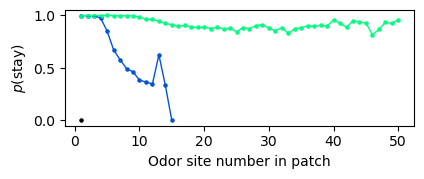

In [49]:
plot_staying_probability_for_reward_site([
        '../../results/rl_agent_outputs/fixed_odor_acc_reward_2025-02-09_18_56_19_657542_var_noise_0.0001_activity_weight_1.0/state',
    ],
    max_reward_param=30,
    max_reward_sites=50,
)

['00050.pkl', '00100.pkl', '00150.pkl', '00200.pkl', '00250.pkl', '00300.pkl', '00350.pkl', '00400.pkl', '00450.pkl', '00500.pkl', '00550.pkl', '00600.pkl', '00650.pkl', '00700.pkl', '00750.pkl', '00800.pkl', '00850.pkl', '00900.pkl', '00950.pkl', '01000.pkl', '01050.pkl', '01100.pkl', '01150.pkl', '01200.pkl', '01250.pkl', '01300.pkl', '01350.pkl', '01400.pkl', '01450.pkl', '01500.pkl', '01550.pkl', '01600.pkl', '01650.pkl', '01700.pkl', '01750.pkl', '01800.pkl', '01850.pkl', '01900.pkl', '01950.pkl', '02000.pkl', '02050.pkl', '02100.pkl']


C:\Users\david.bell\AppData\Local\Temp\ipykernel_24736\2282432297.py:63: RuntimeWarning: invalid value encountered in divide
  cdf[1:] = cdf[1:] / cdf[0:-1]
C:\Users\david.bell\AppData\Local\Temp\ipykernel_24736\2282432297.py:75: RuntimeWarning: Mean of empty slice
  cdf = np.nanmean(all_cdfs[k, ...], axis=0)


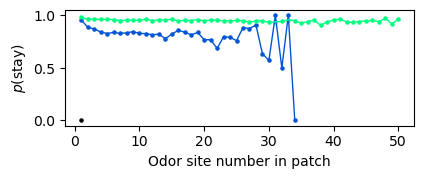

In [50]:
plot_staying_probability_for_reward_site([
        '../../results/rl_agent_outputs/fixed_odor_acc_reward_2025-02-09_18_56_19_657542_var_noise_0.0001_activity_weight_1.0/state',
    ],
    max_reward_param=30,
    max_reward_sites=50,
    update_num=0,
)

['00050.pkl', '00100.pkl', '00150.pkl', '00200.pkl', '00250.pkl', '00300.pkl', '00350.pkl', '00400.pkl', '00450.pkl', '00500.pkl', '00550.pkl', '00600.pkl', '00650.pkl', '00700.pkl', '00750.pkl', '00800.pkl', '00850.pkl', '00900.pkl', '00950.pkl', '01000.pkl', '01050.pkl', '01100.pkl', '01150.pkl', '01200.pkl', '01250.pkl', '01300.pkl', '01350.pkl', '01400.pkl', '01450.pkl', '01500.pkl', '01550.pkl', '01600.pkl', '01650.pkl', '01700.pkl', '01750.pkl', '01800.pkl', '01850.pkl', '01900.pkl', '01950.pkl', '02000.pkl', '02050.pkl', '02100.pkl']


C:\Users\david.bell\AppData\Local\Temp\ipykernel_24736\2282432297.py:63: RuntimeWarning: invalid value encountered in divide
  cdf[1:] = cdf[1:] / cdf[0:-1]
C:\Users\david.bell\AppData\Local\Temp\ipykernel_24736\2282432297.py:75: RuntimeWarning: Mean of empty slice
  cdf = np.nanmean(all_cdfs[k, ...], axis=0)


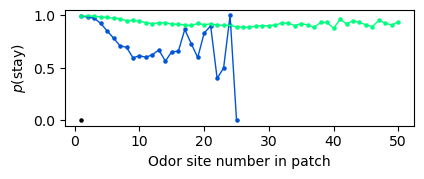

In [51]:
plot_staying_probability_for_reward_site([
        '../../results/rl_agent_outputs/fixed_odor_acc_reward_2025-02-09_18_56_19_657542_var_noise_0.0001_activity_weight_1.0/state',
    ],
    max_reward_param=30,
    max_reward_sites=50,
    update_num=1,
)

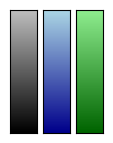

In [116]:
def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(*rgb)

def hex_to_rgb(hex_color):
    return np.array([int(hex_color[i:i+2], 16) for i in (1, 3, 5)]) / 255.0

def generate_colorscale(start_hex, end_hex, n=100):
    start_rgb = np.array([int(start_hex[i:i+2], 16) for i in (1, 3, 5)])
    end_rgb = np.array([int(end_hex[i:i+2], 16) for i in (1, 3, 5)])
    gradient = [tuple(map(int, start_rgb + (end_rgb - start_rgb) * t / (n - 1))) for t in range(n)]
    return [hex_to_rgb(rgb_to_hex(rgb)) for rgb in gradient]

def plot_colorscales(colorscales):
    scale = 0.2
    fig, ax = plt.subplots(1, len(colorscales), figsize=(scale *2 * len(colorscales), scale *8))
    if len(colorscales) == 1:
        ax = [ax]  # Ensure ax is iterable when there's only one column
    
    for i, scale in enumerate(colorscales):
        ax[i].imshow(np.array(scale).reshape(-1, 1, 3), aspect='auto')
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        # ax[i].set_title(f'Color Scale {i+1}')
    
    plt.show()

color_shades = [
    [rgb_to_hex((192, 192, 192)), rgb_to_hex((128, 128, 128)), rgb_to_hex((0, 0, 0))],  # Grey to Black shades
    [rgb_to_hex((173, 216, 230)), rgb_to_hex((0, 0, 205)), rgb_to_hex((0, 0, 139))],  # Blue shades
    [rgb_to_hex((144, 238, 144)), rgb_to_hex((34, 139, 34)), rgb_to_hex((0, 100, 0))],  # Green shades
]

colorscales = [generate_colorscale(row[0], row[-1]) for row in color_shades]

plot_colorscales(colorscales)


In [17]:
def plot_staying_probability_for_acc_reward(data_paths, update_nums=[], max_reward_param=30, max_acc_reward=40, model_colors=None):

    cmap = mpl.colormaps['winter']

    scale = 1.5
    fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 1 * scale), sharex=True, sharey=True)
    axs = [axs]

    for idx_data_path, data_path in enumerate(data_paths):

        for update_idx, update_num in enumerate(update_nums):

            d = load_behavioral_data(data_path, update_num)
    
            all_cdfs = np.empty((3, 30, max_acc_reward))
        
            for env_idx in range(30):
                b_data = parse_behavioral_data(d, env_idx)
                rewards_at_positions = b_data['rewards_at_positions']
                reward_attempted_at_positions = b_data['reward_attempted_at_positions']
                all_patch_nums = b_data['current_patch_num']
                all_patch_reward_params = b_data['patch_reward_param']
                rewards_seen_in_patch = b_data['rewards_seen_in_patch']
                
                reward_param_of_stop = []
                site_idx_of_stop =  []
                acc_reward_stops_for_patch_type = np.zeros((all_patch_nums.max() + 1, 40))
                acc_reward_stop_opportunities_for_patch_type = np.zeros((all_patch_nums.max() + 1, 40))
                patches_entered_for_patch_type = np.zeros((np.array(all_patch_nums).max() + 1,))
                reward_param_for_patch_type = np.zeros((np.array(all_patch_nums).max() + 1,))
                
                last_pstart = None
                last_reward_site_start = None
                patch_count = 0
                for i, pstart in enumerate(b_data['current_patch_start']):
                    # print(f'Step {i}')
                    if last_pstart is None or (pstart != last_pstart).any():
                        patches_entered_for_patch_type[all_patch_nums[i]] += 1
                        reward_param_for_patch_type[all_patch_nums[i]] = all_patch_reward_params[i]
                        patch_count += 1
                        pb = [pstart, pstart]
                        rw_site_counter = 0
                    
                    rwsb = copy(b_data['reward_bounds'][i])
                    reward_site_start = int(rwsb[0])
    
                    # print('rwsite_start', reward_site_start)
                    # print('last_rwsite_start', last_reward_site_start)
                    if last_reward_site_start is None or last_reward_site_start != reward_site_start:
                        if rewards_seen_in_patch[i] < max_acc_reward:
                            acc_reward_stop_opportunities_for_patch_type[all_patch_nums[i], int(rewards_seen_in_patch[i])] += 1
                        
                        if np.sum(reward_attempted_at_positions[int(rwsb[0]):int(rwsb[1])]) == 0:
                            pb[1] = rwsb[1]
                        else:
                            reward_param_of_stop.append(b_data['patch_reward_param'][i])
                            site_idx_of_stop.append(rw_site_counter)
    
                            if rewards_seen_in_patch[i] < max_acc_reward:
                                acc_reward_stops_for_patch_type[all_patch_nums[i], int(rewards_seen_in_patch[i])] += 1
                            rw_site_counter += 1
            
                    last_pstart = pstart
                    last_reward_site_start = reward_site_start
               
                for k in range(all_cdfs.shape[0]):
                    cdf = acc_reward_stops_for_patch_type[k, :] / acc_reward_stop_opportunities_for_patch_type[k, :]
    
                    all_cdfs[k, env_idx, :] = cdf
                    # c = cmap(reward_param_for_patch_type[k] / max_reward_param) if reward_param_for_patch_type[k] > 0 else 'black'
                    # axs[0].plot(x, cdf, color=c, lw=1)
                    # axs[0].scatter(x, cdf, color=c, s=5)
                    # axs[0].set_ylim(-0.1, 1.1)
    
            x = np.arange(0, max_acc_reward)
            for k in range(all_cdfs.shape[0]):
                c = color_shades[k][update_idx] 
                cdf = np.nanmean(all_cdfs[k, ...], axis=0)
                axs[0].plot(x, cdf, color=c, lw=2)
                if k == 0:
                    axs[0].scatter(x, cdf, color=c, s=10)

        axs[0].set_xlim(-1, max_acc_reward + 1)
    
        axs[0].set_ylabel(r'$p(\mathrm{stay})$')
        axs[0].set_xlabel('Acc. reward in patch')

        axs[0].spines['top'].set_visible(False)
        axs[0].spines['right'].set_visible(False)
        axs[0].spines['bottom'].set_linewidth(2.5)
        axs[0].spines['left'].set_linewidth(2.5)

    fig.savefig('../../results/figures/he_init_agent_stopping_probs_acc_reward.svg', bbox_inches='tight')


['00050.pkl', '00100.pkl', '00150.pkl', '00200.pkl', '00250.pkl', '00300.pkl', '00350.pkl', '00400.pkl', '00450.pkl', '00500.pkl', '00550.pkl', '00600.pkl', '00650.pkl', '00700.pkl', '00750.pkl', '00800.pkl', '00850.pkl', '00900.pkl', '00950.pkl', '01000.pkl', '01050.pkl', '01100.pkl', '01150.pkl', '01200.pkl', '01250.pkl', '01300.pkl', '01350.pkl', '01400.pkl', '01450.pkl', '01500.pkl', '01550.pkl', '01600.pkl', '01650.pkl', '01700.pkl', '01750.pkl', '01800.pkl', '01850.pkl', '01900.pkl', '01950.pkl', '02000.pkl', '02050.pkl', '02100.pkl']


C:\Users\david.bell\AppData\Local\Temp\ipykernel_24736\2374128071.py:67: RuntimeWarning: invalid value encountered in divide
  cdf = acc_reward_stops_for_patch_type[k, :] / acc_reward_stop_opportunities_for_patch_type[k, :]
C:\Users\david.bell\AppData\Local\Temp\ipykernel_24736\2374128071.py:78: RuntimeWarning: Mean of empty slice
  cdf = np.nanmean(all_cdfs[k, ...], axis=0)


['00050.pkl', '00100.pkl', '00150.pkl', '00200.pkl', '00250.pkl', '00300.pkl', '00350.pkl', '00400.pkl', '00450.pkl', '00500.pkl', '00550.pkl', '00600.pkl', '00650.pkl', '00700.pkl', '00750.pkl', '00800.pkl', '00850.pkl', '00900.pkl', '00950.pkl', '01000.pkl', '01050.pkl', '01100.pkl', '01150.pkl', '01200.pkl', '01250.pkl', '01300.pkl', '01350.pkl', '01400.pkl', '01450.pkl', '01500.pkl', '01550.pkl', '01600.pkl', '01650.pkl', '01700.pkl', '01750.pkl', '01800.pkl', '01850.pkl', '01900.pkl', '01950.pkl', '02000.pkl', '02050.pkl', '02100.pkl']
['00050.pkl', '00100.pkl', '00150.pkl', '00200.pkl', '00250.pkl', '00300.pkl', '00350.pkl', '00400.pkl', '00450.pkl', '00500.pkl', '00550.pkl', '00600.pkl', '00650.pkl', '00700.pkl', '00750.pkl', '00800.pkl', '00850.pkl', '00900.pkl', '00950.pkl', '01000.pkl', '01050.pkl', '01100.pkl', '01150.pkl', '01200.pkl', '01250.pkl', '01300.pkl', '01350.pkl', '01400.pkl', '01450.pkl', '01500.pkl', '01550.pkl', '01600.pkl', '01650.pkl', '01700.pkl', '01750.pkl

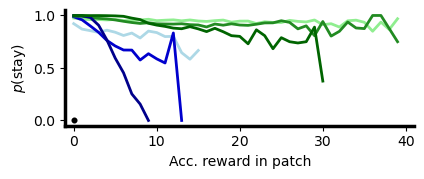

In [125]:
plot_staying_probability_for_acc_reward([
        '../../results/rl_agent_outputs/fixed_odor_acc_reward_2025-02-09_18_56_19_657542_var_noise_0.0001_activity_weight_1.0/state',
    ],
    max_acc_reward=40,
    update_nums=[0, 1, 21],
)

TypeError: object of type 'generator' has no len()

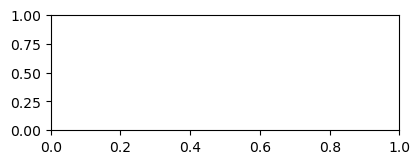

In [26]:
plot_staying_probability_for_acc_reward([
        '../../results/rl_agent_outputs/test_augment_pretrain_2025-03-21_13_41_00_398273_var_noise_0_activity_weight_0_sn_02000/state',
    ],
    max_acc_reward=40,
    update_nums=[3],
)